In [12]:
import torch
import torch.nn as nn
import numpy as np

class DataEmbedding(nn.Module):
    def __init__(self, feats_in: int, feats_model: int, embedding_type: str = 'fixed', frequency: str = 'h', dropout: float = 0.1):
        super(DataEmbedding, self).__init__()
        self.value_embedding = nn.Linear(feats_in, feats_model)  # [1] -> [d_model]
        self.position_embedding = PositionalEmbedding(feats_model=feats_model)
        self.temporal_embedding = TemporalEmbedding(feats_model=feats_model, embedding_type=embedding_type, frequency=frequency)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor, x_mark: torch.Tensor) -> torch.Tensor:
        # x shape: [B, T, 1]
        x_emb = self.value_embedding(x)  # [B, T, 1] -> [B, T, d_model]
        x_emb = x_emb + self.position_embedding(x)  # [B, T, d_model]

        if x_mark is not None:
            x_emb += self.temporal_embedding(x_mark)

        return self.dropout(x_emb)

class TemporalEmbedding(nn.Module):
    def __init__(self, feats_model: int, embedding_type: str = 'timeF', frequency: str = 'h'):
        super(TemporalEmbedding, self).__init__()

        # 시간 주기별 임베딩 차원
        Embed = nn.Embedding

        # 시간 주기 구성: 시간 단위에 따라 다르게 처리
        if frequency == 'h':
            self.minute_embed = None
            self.hour_embed = Embed(24, feats_model)       # 0~23
            self.weekday_embed = Embed(7, feats_model)     # 0~6
            self.day_embed = Embed(32, feats_model)        # 1~31
            self.month_embed = Embed(13, feats_model)      # 1~12
        else:
            raise NotImplementedError(f"Unsupported frequency: {frequency}")

    def forward(self, x_mark: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x_mark : Tensor of shape [B, T, 4] → columns: hour, weekday, day, month

        Returns
        -------
        Tensor of shape [B, T, d_model]
        """
        hour_x = self.hour_embed(x_mark[:, :, 0].long())
        weekday_x = self.weekday_embed(x_mark[:, :, 1].long())
        day_x = self.day_embed(x_mark[:, :, 2].long())
        month_x = self.month_embed(x_mark[:, :, 3].long())

        return hour_x + weekday_x + day_x + month_x


class PositionalEmbedding(nn.Module):
    def __init__(self, feats_model: int, max_len: int = 5000):
        super(PositionalEmbedding, self).__init__()

        # 위치 인덱스 (0, 1, 2, ..., max_len - 1)
        pe = torch.zeros(max_len, feats_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, feats_model, 2).float() * (-np.log(10000.0) / feats_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : Tensor of shape [batch_size, seq_len, feats_model]
        """
        return self.pe[:, :x.size(1), :]


class Inception_Block_V1(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=6, init_weight=True):
        super(Inception_Block_V1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels
        kernels = []
        for i in range(self.num_kernels):
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=2 * i + 1, padding=i))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res


class Inception_Block_V2(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=6, init_weight=True):
        super(Inception_Block_V2, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels
        kernels = []
        for i in range(self.num_kernels // 2):
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=[1, 2 * i + 3], padding=[0, i + 1]))
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=[2 * i + 3, 1], padding=[i + 1, 0]))
        kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels + 1):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res



In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft

def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]


class TimesBlock(nn.Module):
    def __init__(self, configs):
        super(TimesBlock, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.k = configs.top_k
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(configs.d_model, configs.d_ff,
                               num_kernels=configs.num_kernels),
            nn.GELU(),
            Inception_Block_V1(configs.d_ff, configs.d_model,
                               num_kernels=configs.num_kernels)
        )

    def forward(self, x):
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = (
                                 ((self.seq_len + self.pred_len) // period) + 1) * period
                padding = torch.zeros([x.shape[0], (length - (self.seq_len + self.pred_len)), x.shape[2]]).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = (self.seq_len + self.pred_len)
                out = x
            # reshape
            out = out.reshape(B, length // period, period,
                              N).permute(0, 3, 1, 2).contiguous()
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, :(self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1)
        # adaptive aggregation
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(
            1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        # residual connection
        res = res + x
        return res

class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.configs = configs
        self.task_name = configs.task_name
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.model = nn.ModuleList([TimesBlock(configs)
                                  for _ in range(configs.e_layers)])
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                         configs.dropout)
        self.layer = configs.e_layers
        self.layer_norm = nn.LayerNorm(configs.d_model)

        # Always initialize projection layer for regression
        self.projection = nn.Linear(configs.d_model, configs.c_out, bias=True)

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # Normalization
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev

        # Embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)  # [B,T,C]

        # TimesNet blocks
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))

        # Projection
        dec_out = self.projection(enc_out)

        # De-normalization
        dec_out = dec_out * stdev[:, 0, :].unsqueeze(1).repeat(1, self.seq_len, 1)
        dec_out = dec_out + means[:, 0, :].unsqueeze(1).repeat(1, self.seq_len, 1)

        return dec_out

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
        return dec_out.mean(dim=1)  # Average over time dimension to get [B, 2]


In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

# 0. Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# TimesNet 설정 클래스
def get_config(seq_len, pred_len, input_dim, output_dim):
    class Config:
        def __init__(self):
            self.task_name = 'regression'
            self.enc_in = input_dim
            self.c_out = output_dim
            self.d_model = 64
            self.d_ff = 128
            self.num_kernels = 6
            self.top_k = 3
            self.embed = 'timeF'
            self.freq = 'h'
            self.dropout = 0.1
            self.seq_len = seq_len
            self.label_len = 0
            self.pred_len = pred_len
            self.e_layers = 2
    return Config()

# 1. Load Data
file_path = "/content/combined_dataset-1.xlsx"
df = pd.read_excel(file_path)

# 2. Feature & Target Selection
X_raw = df[[str(i) for i in range(1, 2101)]].dropna()
y_sbp = df.loc[X_raw.index, 'Systolic Blood Pressure(mmHg)']
y_dbp = df.loc[X_raw.index, 'Diastolic Blood Pressure(mmHg)']

# 3. Sliding Window Transform
def sliding_window_transform(X_raw, y_sbp, y_dbp, window_size, stride):
    X_win, y_win = [], []
    for i in range(len(X_raw)):
        row = X_raw.iloc[i].values
        for start in range(0, 2100 - window_size + 1, stride):
            end = start + window_size
            X_win.append(row[start:end])
            y_win.append([y_sbp.iloc[i], y_dbp.iloc[i]])
    return np.array(X_win), np.array(y_win)

window_size = 200
stride = 200
X_win, y_win = sliding_window_transform(X_raw, y_sbp, y_dbp, window_size, stride)

# 4. Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_win.reshape(-1, window_size)).reshape(X_win.shape)

# 5. Tensor Conversion (B, T, 1)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, 1)
y_tensor = torch.tensor(y_win, dtype=torch.float32)  # (batch, 2)

# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# 7. DataLoader 구성
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 8. 모델 설정
config = get_config(seq_len=window_size, pred_len=0, input_dim=1, output_dim=2)

# !!! 반드시 사전에 정의된 TimesNet 또는 Model 클래스를 불러오세요 !!!
model = Model(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()

# 9. 훈련
best_val_loss = float('inf')
epochs = 500

for epoch in range(epochs) :
    model.train()
    train_loss = 0
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/200 [TRAIN]', leave=False)

    for xb, yb in train_bar:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb, None, None, None)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0
    val_sbp_mae = 0
    val_dbp_mae = 0

    with torch.no_grad():
        val_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/200 [VAL]', leave=False)
        for xb, yb in val_bar:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb, None, None, None)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()

            sbp_mae = mean_absolute_error(yb[:, 0].cpu().numpy(), pred[:, 0].cpu().numpy())
            dbp_mae = mean_absolute_error(yb[:, 1].cpu().numpy(), pred[:, 1].cpu().numpy())
            val_sbp_mae += sbp_mae
            val_dbp_mae += dbp_mae

    avg_val_loss = val_loss / len(test_loader)
    avg_sbp_mae = val_sbp_mae / len(test_loader)
    avg_dbp_mae = val_dbp_mae / len(test_loader)

    print(f'\nEpoch {epoch+1}/{epochs}')
    print(f'Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
    print(f'Val MAE - SBP: {avg_sbp_mae:.2f} mmHg | DBP: {avg_dbp_mae:.2f} mmHg')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Best model saved (Val Loss: {best_val_loss:.4f})')

print('\nTraining completed!')

# 10. 평가
model.eval()
with torch.no_grad():
    X_test_gpu = X_test.to(device)
    pred_test = model(X_test_gpu, None, None, None).mean(dim=1)
    mae_sbp = mean_absolute_error(y_test[:, 0].numpy(), pred_test[:, 0].cpu().numpy())
    mae_dbp = mean_absolute_error(y_test[:, 1].numpy(), pred_test[:, 1].cpu().numpy())

print(f"MAE (SBP): {mae_sbp:.2f} mmHg")
print(f"MAE (DBP): {mae_dbp:.2f} mmHg")


Using device: cuda



Epoch 1/500
Train Loss: 98.2283 | Val Loss: 97.1022
Val MAE - SBP: 125.28 mmHg | DBP: 68.92 mmHg
Best model saved (Val Loss: 97.1022)



Epoch 2/500
Train Loss: 95.6518 | Val Loss: 93.8991
Val MAE - SBP: 122.22 mmHg | DBP: 65.58 mmHg
Best model saved (Val Loss: 93.8991)



Epoch 3/500
Train Loss: 92.0419 | Val Loss: 89.7685
Val MAE - SBP: 117.94 mmHg | DBP: 61.60 mmHg
Best model saved (Val Loss: 89.7685)



Epoch 4/500
Train Loss: 87.7118 | Val Loss: 85.2616
Val MAE - SBP: 113.11 mmHg | DBP: 57.41 mmHg
Best model saved (Val Loss: 85.2616)



Epoch 5/500
Train Loss: 83.1990 | Val Loss: 80.8711
Val MAE - SBP: 107.99 mmHg | DBP: 53.76 mmHg
Best model saved (Val Loss: 80.8711)



Epoch 6/500
Train Loss: 78.7005 | Val Loss: 76.8117
Val MAE - SBP: 102.63 mmHg | DBP: 50.99 mmHg
Best model saved (Val Loss: 76.8117)



Epoch 7/500
Train Loss: 75.1181 | Val Loss: 73.6841
Val MAE - SBP: 98.07 mmHg | DBP: 49.30 mmHg
Best model saved (Val Loss: 73.6841)



Epoch 8/500
Train Loss: 72.1679 | Val Loss: 71.1834
Val MAE - SBP: 94.10 mmHg | DBP: 48.27 mmHg
Best model saved (Val Loss: 71.1834)



Epoch 9/500
Train Loss: 69.7846 | Val Loss: 69.0828
Val MAE - SBP: 90.88 mmHg | DBP: 47.28 mmHg
Best model saved (Val Loss: 69.0828)



Epoch 10/500
Train Loss: 67.7024 | Val Loss: 67.1584
Val MAE - SBP: 88.25 mmHg | DBP: 46.07 mmHg
Best model saved (Val Loss: 67.1584)



Epoch 11/500
Train Loss: 66.3430 | Val Loss: 65.8184
Val MAE - SBP: 86.03 mmHg | DBP: 45.61 mmHg
Best model saved (Val Loss: 65.8184)



Epoch 12/500
Train Loss: 65.0239 | Val Loss: 64.3968
Val MAE - SBP: 83.91 mmHg | DBP: 44.88 mmHg
Best model saved (Val Loss: 64.3968)



Epoch 13/500
Train Loss: 63.8680 | Val Loss: 62.9901
Val MAE - SBP: 82.08 mmHg | DBP: 43.90 mmHg
Best model saved (Val Loss: 62.9901)



Epoch 14/500
Train Loss: 62.4798 | Val Loss: 62.5624
Val MAE - SBP: 80.99 mmHg | DBP: 44.14 mmHg
Best model saved (Val Loss: 62.5624)



Epoch 15/500
Train Loss: 61.5046 | Val Loss: 60.6402
Val MAE - SBP: 78.66 mmHg | DBP: 42.62 mmHg
Best model saved (Val Loss: 60.6402)



Epoch 16/500
Train Loss: 60.1712 | Val Loss: 59.9009
Val MAE - SBP: 77.39 mmHg | DBP: 42.41 mmHg
Best model saved (Val Loss: 59.9009)



Epoch 17/500
Train Loss: 59.5129 | Val Loss: 59.2877
Val MAE - SBP: 76.71 mmHg | DBP: 41.86 mmHg
Best model saved (Val Loss: 59.2877)



Epoch 18/500
Train Loss: 59.2706 | Val Loss: 59.2181
Val MAE - SBP: 76.17 mmHg | DBP: 42.27 mmHg
Best model saved (Val Loss: 59.2181)



Epoch 19/500
Train Loss: 58.5448 | Val Loss: 57.9287
Val MAE - SBP: 74.51 mmHg | DBP: 41.34 mmHg
Best model saved (Val Loss: 57.9287)



Epoch 20/500
Train Loss: 57.6339 | Val Loss: 57.5029
Val MAE - SBP: 73.91 mmHg | DBP: 41.10 mmHg
Best model saved (Val Loss: 57.5029)



Epoch 21/500
Train Loss: 57.4555 | Val Loss: 57.1715
Val MAE - SBP: 73.29 mmHg | DBP: 41.06 mmHg
Best model saved (Val Loss: 57.1715)



Epoch 22/500
Train Loss: 57.0520 | Val Loss: 57.3738
Val MAE - SBP: 73.37 mmHg | DBP: 41.38 mmHg



Epoch 23/500
Train Loss: 57.1902 | Val Loss: 56.7357
Val MAE - SBP: 72.62 mmHg | DBP: 40.85 mmHg
Best model saved (Val Loss: 56.7357)



Epoch 24/500
Train Loss: 56.6257 | Val Loss: 55.9207
Val MAE - SBP: 72.11 mmHg | DBP: 39.73 mmHg
Best model saved (Val Loss: 55.9207)



Epoch 25/500
Train Loss: 56.6886 | Val Loss: 57.5941
Val MAE - SBP: 74.10 mmHg | DBP: 41.09 mmHg



Epoch 26/500
Train Loss: 54.9373 | Val Loss: 54.3420
Val MAE - SBP: 70.10 mmHg | DBP: 38.58 mmHg
Best model saved (Val Loss: 54.3420)



Epoch 27/500
Train Loss: 53.8943 | Val Loss: 53.8253
Val MAE - SBP: 69.41 mmHg | DBP: 38.24 mmHg
Best model saved (Val Loss: 53.8253)



Epoch 28/500
Train Loss: 53.3419 | Val Loss: 53.1376
Val MAE - SBP: 68.71 mmHg | DBP: 37.57 mmHg
Best model saved (Val Loss: 53.1376)



Epoch 29/500
Train Loss: 52.5152 | Val Loss: 52.2918
Val MAE - SBP: 67.25 mmHg | DBP: 37.33 mmHg
Best model saved (Val Loss: 52.2918)



Epoch 30/500
Train Loss: 51.8855 | Val Loss: 51.0977
Val MAE - SBP: 66.05 mmHg | DBP: 36.14 mmHg
Best model saved (Val Loss: 51.0977)



Epoch 31/500
Train Loss: 50.5240 | Val Loss: 50.0494
Val MAE - SBP: 64.88 mmHg | DBP: 35.22 mmHg
Best model saved (Val Loss: 50.0494)



Epoch 32/500
Train Loss: 50.3120 | Val Loss: 49.5013
Val MAE - SBP: 64.00 mmHg | DBP: 35.00 mmHg
Best model saved (Val Loss: 49.5013)



Epoch 33/500
Train Loss: 48.9739 | Val Loss: 53.1870
Val MAE - SBP: 67.22 mmHg | DBP: 39.16 mmHg



Epoch 34/500
Train Loss: 48.8354 | Val Loss: 46.2003
Val MAE - SBP: 60.06 mmHg | DBP: 32.34 mmHg
Best model saved (Val Loss: 46.2003)



Epoch 35/500
Train Loss: 46.6957 | Val Loss: 46.5022
Val MAE - SBP: 60.42 mmHg | DBP: 32.58 mmHg



Epoch 36/500
Train Loss: 47.5779 | Val Loss: 44.8551
Val MAE - SBP: 58.25 mmHg | DBP: 31.46 mmHg
Best model saved (Val Loss: 44.8551)



Epoch 37/500
Train Loss: 45.7749 | Val Loss: 45.1002
Val MAE - SBP: 58.65 mmHg | DBP: 31.55 mmHg



Epoch 38/500
Train Loss: 45.3581 | Val Loss: 44.9909
Val MAE - SBP: 58.12 mmHg | DBP: 31.87 mmHg



Epoch 39/500
Train Loss: 44.3503 | Val Loss: 44.8011
Val MAE - SBP: 58.09 mmHg | DBP: 31.51 mmHg
Best model saved (Val Loss: 44.8011)



Epoch 40/500
Train Loss: 44.3953 | Val Loss: 43.2297
Val MAE - SBP: 55.95 mmHg | DBP: 30.51 mmHg
Best model saved (Val Loss: 43.2297)



Epoch 41/500
Train Loss: 43.3043 | Val Loss: 44.3046
Val MAE - SBP: 56.87 mmHg | DBP: 31.74 mmHg



Epoch 42/500
Train Loss: 43.7998 | Val Loss: 41.9457
Val MAE - SBP: 54.09 mmHg | DBP: 29.80 mmHg
Best model saved (Val Loss: 41.9457)



Epoch 43/500
Train Loss: 42.1780 | Val Loss: 41.8948
Val MAE - SBP: 54.16 mmHg | DBP: 29.63 mmHg
Best model saved (Val Loss: 41.8948)



Epoch 44/500
Train Loss: 43.0084 | Val Loss: 41.4456
Val MAE - SBP: 53.67 mmHg | DBP: 29.22 mmHg
Best model saved (Val Loss: 41.4456)



Epoch 45/500
Train Loss: 43.3620 | Val Loss: 43.3161
Val MAE - SBP: 55.60 mmHg | DBP: 31.03 mmHg



Epoch 46/500
Train Loss: 41.7416 | Val Loss: 41.5723
Val MAE - SBP: 53.47 mmHg | DBP: 29.67 mmHg



Epoch 47/500
Train Loss: 40.9051 | Val Loss: 40.9939
Val MAE - SBP: 52.84 mmHg | DBP: 29.14 mmHg
Best model saved (Val Loss: 40.9939)



Epoch 48/500
Train Loss: 41.1236 | Val Loss: 40.8288
Val MAE - SBP: 52.57 mmHg | DBP: 29.09 mmHg
Best model saved (Val Loss: 40.8288)



Epoch 49/500
Train Loss: 40.0894 | Val Loss: 42.4511
Val MAE - SBP: 54.51 mmHg | DBP: 30.40 mmHg



Epoch 50/500
Train Loss: 42.3165 | Val Loss: 43.1347
Val MAE - SBP: 55.04 mmHg | DBP: 31.23 mmHg



Epoch 51/500
Train Loss: 40.1840 | Val Loss: 39.5716
Val MAE - SBP: 50.87 mmHg | DBP: 28.28 mmHg
Best model saved (Val Loss: 39.5716)



Epoch 52/500
Train Loss: 39.9497 | Val Loss: 40.9000
Val MAE - SBP: 52.57 mmHg | DBP: 29.23 mmHg



Epoch 53/500
Train Loss: 39.4793 | Val Loss: 39.4789
Val MAE - SBP: 50.64 mmHg | DBP: 28.32 mmHg
Best model saved (Val Loss: 39.4789)



Epoch 54/500
Train Loss: 39.7797 | Val Loss: 40.4220
Val MAE - SBP: 51.81 mmHg | DBP: 29.03 mmHg



Epoch 55/500
Train Loss: 39.0334 | Val Loss: 39.9609
Val MAE - SBP: 51.18 mmHg | DBP: 28.74 mmHg



Epoch 56/500
Train Loss: 38.6482 | Val Loss: 39.4220
Val MAE - SBP: 50.45 mmHg | DBP: 28.40 mmHg
Best model saved (Val Loss: 39.4220)



Epoch 57/500
Train Loss: 39.1517 | Val Loss: 38.7712
Val MAE - SBP: 49.86 mmHg | DBP: 27.68 mmHg
Best model saved (Val Loss: 38.7712)



Epoch 58/500
Train Loss: 38.3200 | Val Loss: 38.4457
Val MAE - SBP: 49.39 mmHg | DBP: 27.50 mmHg
Best model saved (Val Loss: 38.4457)



Epoch 59/500
Train Loss: 38.3715 | Val Loss: 38.7347
Val MAE - SBP: 49.60 mmHg | DBP: 27.87 mmHg



Epoch 60/500
Train Loss: 38.3132 | Val Loss: 41.1204
Val MAE - SBP: 52.65 mmHg | DBP: 29.59 mmHg



Epoch 61/500
Train Loss: 38.5795 | Val Loss: 37.7130
Val MAE - SBP: 48.53 mmHg | DBP: 26.90 mmHg
Best model saved (Val Loss: 37.7130)



Epoch 62/500
Train Loss: 37.5279 | Val Loss: 41.9932
Val MAE - SBP: 53.49 mmHg | DBP: 30.50 mmHg



Epoch 63/500
Train Loss: 38.2973 | Val Loss: 37.7375
Val MAE - SBP: 48.45 mmHg | DBP: 27.03 mmHg



Epoch 64/500
Train Loss: 37.9402 | Val Loss: 38.4394
Val MAE - SBP: 49.29 mmHg | DBP: 27.59 mmHg



Epoch 65/500
Train Loss: 37.8474 | Val Loss: 40.8647
Val MAE - SBP: 52.45 mmHg | DBP: 29.28 mmHg



Epoch 66/500
Train Loss: 37.3614 | Val Loss: 38.3645
Val MAE - SBP: 49.19 mmHg | DBP: 27.54 mmHg



Epoch 67/500
Train Loss: 37.8869 | Val Loss: 39.9697
Val MAE - SBP: 51.21 mmHg | DBP: 28.73 mmHg



Epoch 68/500
Train Loss: 38.4185 | Val Loss: 38.7064
Val MAE - SBP: 49.58 mmHg | DBP: 27.83 mmHg



Epoch 69/500
Train Loss: 37.2003 | Val Loss: 37.8116
Val MAE - SBP: 48.41 mmHg | DBP: 27.21 mmHg



Epoch 70/500
Train Loss: 37.4958 | Val Loss: 37.8112
Val MAE - SBP: 48.44 mmHg | DBP: 27.19 mmHg



Epoch 71/500
Train Loss: 36.7875 | Val Loss: 37.4338
Val MAE - SBP: 48.15 mmHg | DBP: 26.72 mmHg
Best model saved (Val Loss: 37.4338)



Epoch 72/500
Train Loss: 37.3232 | Val Loss: 37.1189
Val MAE - SBP: 47.63 mmHg | DBP: 26.61 mmHg
Best model saved (Val Loss: 37.1189)



Epoch 73/500
Train Loss: 37.1375 | Val Loss: 36.8254
Val MAE - SBP: 47.28 mmHg | DBP: 26.38 mmHg
Best model saved (Val Loss: 36.8254)



Epoch 74/500
Train Loss: 36.8900 | Val Loss: 37.1166
Val MAE - SBP: 47.61 mmHg | DBP: 26.63 mmHg



Epoch 75/500
Train Loss: 36.7952 | Val Loss: 36.8995
Val MAE - SBP: 47.41 mmHg | DBP: 26.39 mmHg



Epoch 76/500
Train Loss: 36.7643 | Val Loss: 38.4678
Val MAE - SBP: 49.17 mmHg | DBP: 27.77 mmHg



Epoch 77/500
Train Loss: 36.8532 | Val Loss: 36.9859
Val MAE - SBP: 47.42 mmHg | DBP: 26.55 mmHg



Epoch 78/500
Train Loss: 37.0451 | Val Loss: 38.4127
Val MAE - SBP: 49.26 mmHg | DBP: 27.56 mmHg



Epoch 79/500
Train Loss: 37.2837 | Val Loss: 37.2690
Val MAE - SBP: 47.77 mmHg | DBP: 26.77 mmHg



Epoch 80/500
Train Loss: 36.6925 | Val Loss: 36.7775
Val MAE - SBP: 47.21 mmHg | DBP: 26.35 mmHg
Best model saved (Val Loss: 36.7775)



Epoch 81/500
Train Loss: 36.0869 | Val Loss: 39.3572
Val MAE - SBP: 50.36 mmHg | DBP: 28.35 mmHg



Epoch 82/500
Train Loss: 36.4579 | Val Loss: 37.2711
Val MAE - SBP: 47.80 mmHg | DBP: 26.74 mmHg



Epoch 83/500
Train Loss: 36.8033 | Val Loss: 36.7453
Val MAE - SBP: 47.10 mmHg | DBP: 26.39 mmHg
Best model saved (Val Loss: 36.7453)



Epoch 84/500
Train Loss: 35.8377 | Val Loss: 36.8287
Val MAE - SBP: 47.21 mmHg | DBP: 26.44 mmHg



Epoch 85/500
Train Loss: 36.6565 | Val Loss: 36.5407
Val MAE - SBP: 46.92 mmHg | DBP: 26.16 mmHg
Best model saved (Val Loss: 36.5407)



Epoch 86/500
Train Loss: 36.5370 | Val Loss: 37.4643
Val MAE - SBP: 48.02 mmHg | DBP: 26.91 mmHg



Epoch 87/500
Train Loss: 36.0218 | Val Loss: 36.8215
Val MAE - SBP: 47.19 mmHg | DBP: 26.45 mmHg



Epoch 88/500
Train Loss: 36.2016 | Val Loss: 36.5129
Val MAE - SBP: 46.75 mmHg | DBP: 26.27 mmHg
Best model saved (Val Loss: 36.5129)



Epoch 89/500
Train Loss: 36.2975 | Val Loss: 37.3358
Val MAE - SBP: 47.90 mmHg | DBP: 26.78 mmHg



Epoch 90/500
Train Loss: 35.8180 | Val Loss: 36.7958
Val MAE - SBP: 47.19 mmHg | DBP: 26.40 mmHg



Epoch 91/500
Train Loss: 36.4245 | Val Loss: 36.2939
Val MAE - SBP: 46.52 mmHg | DBP: 26.07 mmHg
Best model saved (Val Loss: 36.2939)



Epoch 92/500
Train Loss: 36.0132 | Val Loss: 36.5231
Val MAE - SBP: 46.78 mmHg | DBP: 26.27 mmHg



Epoch 93/500
Train Loss: 35.7535 | Val Loss: 36.2435
Val MAE - SBP: 46.48 mmHg | DBP: 26.01 mmHg
Best model saved (Val Loss: 36.2435)



Epoch 94/500
Train Loss: 35.6013 | Val Loss: 37.3219
Val MAE - SBP: 47.82 mmHg | DBP: 26.82 mmHg



Epoch 95/500
Train Loss: 35.9237 | Val Loss: 36.9223
Val MAE - SBP: 47.29 mmHg | DBP: 26.56 mmHg



Epoch 96/500
Train Loss: 35.8513 | Val Loss: 36.0470
Val MAE - SBP: 46.24 mmHg | DBP: 25.85 mmHg
Best model saved (Val Loss: 36.0470)



Epoch 97/500
Train Loss: 36.4216 | Val Loss: 36.7966
Val MAE - SBP: 47.12 mmHg | DBP: 26.47 mmHg



Epoch 98/500
Train Loss: 35.1953 | Val Loss: 36.9609
Val MAE - SBP: 47.36 mmHg | DBP: 26.56 mmHg



Epoch 99/500
Train Loss: 36.0649 | Val Loss: 38.7772
Val MAE - SBP: 49.70 mmHg | DBP: 27.86 mmHg



Epoch 100/500
Train Loss: 35.8189 | Val Loss: 36.3109
Val MAE - SBP: 46.55 mmHg | DBP: 26.07 mmHg



Epoch 101/500
Train Loss: 35.6150 | Val Loss: 37.0701
Val MAE - SBP: 47.42 mmHg | DBP: 26.72 mmHg



Epoch 102/500
Train Loss: 35.5782 | Val Loss: 36.2259
Val MAE - SBP: 46.44 mmHg | DBP: 26.01 mmHg



Epoch 103/500
Train Loss: 35.6135 | Val Loss: 37.4874
Val MAE - SBP: 48.03 mmHg | DBP: 26.95 mmHg



Epoch 104/500
Train Loss: 36.1287 | Val Loss: 37.7955
Val MAE - SBP: 48.41 mmHg | DBP: 27.18 mmHg



Epoch 105/500
Train Loss: 35.6675 | Val Loss: 41.4900
Val MAE - SBP: 53.15 mmHg | DBP: 29.83 mmHg



Epoch 106/500
Train Loss: 35.7362 | Val Loss: 36.7954
Val MAE - SBP: 47.15 mmHg | DBP: 26.44 mmHg



Epoch 107/500
Train Loss: 35.7579 | Val Loss: 36.1417
Val MAE - SBP: 46.35 mmHg | DBP: 25.93 mmHg



Epoch 108/500
Train Loss: 35.7639 | Val Loss: 36.2337
Val MAE - SBP: 46.47 mmHg | DBP: 25.99 mmHg



Epoch 109/500
Train Loss: 35.3489 | Val Loss: 36.1317
Val MAE - SBP: 46.26 mmHg | DBP: 26.01 mmHg



Epoch 110/500
Train Loss: 35.8465 | Val Loss: 43.1233
Val MAE - SBP: 54.89 mmHg | DBP: 31.36 mmHg



Epoch 111/500
Train Loss: 36.4817 | Val Loss: 36.0404
Val MAE - SBP: 46.19 mmHg | DBP: 25.89 mmHg
Best model saved (Val Loss: 36.0404)



Epoch 112/500
Train Loss: 36.0333 | Val Loss: 35.9296
Val MAE - SBP: 46.06 mmHg | DBP: 25.79 mmHg
Best model saved (Val Loss: 35.9296)



Epoch 113/500
Train Loss: 35.6172 | Val Loss: 35.8748
Val MAE - SBP: 46.01 mmHg | DBP: 25.73 mmHg
Best model saved (Val Loss: 35.8748)



Epoch 114/500
Train Loss: 35.2873 | Val Loss: 35.8784
Val MAE - SBP: 46.01 mmHg | DBP: 25.75 mmHg



Epoch 115/500
Train Loss: 34.9995 | Val Loss: 35.9019
Val MAE - SBP: 46.04 mmHg | DBP: 25.77 mmHg



Epoch 116/500
Train Loss: 35.9666 | Val Loss: 36.1023
Val MAE - SBP: 46.29 mmHg | DBP: 25.91 mmHg



Epoch 117/500
Train Loss: 35.5588 | Val Loss: 36.0374
Val MAE - SBP: 46.25 mmHg | DBP: 25.82 mmHg



Epoch 118/500
Train Loss: 35.5720 | Val Loss: 36.0363
Val MAE - SBP: 46.14 mmHg | DBP: 25.93 mmHg



Epoch 119/500
Train Loss: 36.0420 | Val Loss: 35.4066
Val MAE - SBP: 45.38 mmHg | DBP: 25.43 mmHg
Best model saved (Val Loss: 35.4066)



Epoch 120/500
Train Loss: 35.5557 | Val Loss: 35.3377
Val MAE - SBP: 45.26 mmHg | DBP: 25.42 mmHg
Best model saved (Val Loss: 35.3377)



Epoch 121/500
Train Loss: 34.8946 | Val Loss: 36.2521
Val MAE - SBP: 46.41 mmHg | DBP: 26.09 mmHg



Epoch 122/500
Train Loss: 35.3279 | Val Loss: 36.2201
Val MAE - SBP: 46.56 mmHg | DBP: 25.88 mmHg



Epoch 123/500
Train Loss: 35.1161 | Val Loss: 35.0728
Val MAE - SBP: 44.96 mmHg | DBP: 25.19 mmHg
Best model saved (Val Loss: 35.0728)



Epoch 124/500
Train Loss: 35.0991 | Val Loss: 36.2168
Val MAE - SBP: 46.39 mmHg | DBP: 26.04 mmHg



Epoch 125/500
Train Loss: 35.3617 | Val Loss: 35.6765
Val MAE - SBP: 45.73 mmHg | DBP: 25.63 mmHg



Epoch 126/500
Train Loss: 35.2025 | Val Loss: 35.9960
Val MAE - SBP: 46.20 mmHg | DBP: 25.80 mmHg



Epoch 127/500
Train Loss: 34.9386 | Val Loss: 35.6002
Val MAE - SBP: 45.61 mmHg | DBP: 25.59 mmHg



Epoch 128/500
Train Loss: 35.6771 | Val Loss: 36.3569
Val MAE - SBP: 46.69 mmHg | DBP: 26.02 mmHg



Epoch 129/500
Train Loss: 35.1065 | Val Loss: 35.1189
Val MAE - SBP: 45.03 mmHg | DBP: 25.20 mmHg



Epoch 130/500
Train Loss: 35.0681 | Val Loss: 37.4311
Val MAE - SBP: 47.95 mmHg | DBP: 26.91 mmHg



Epoch 131/500
Train Loss: 35.1816 | Val Loss: 35.6537
Val MAE - SBP: 45.73 mmHg | DBP: 25.58 mmHg



Epoch 132/500
Train Loss: 35.4316 | Val Loss: 36.5397
Val MAE - SBP: 46.84 mmHg | DBP: 26.24 mmHg



Epoch 133/500
Train Loss: 35.2393 | Val Loss: 35.9862
Val MAE - SBP: 46.16 mmHg | DBP: 25.81 mmHg



Epoch 134/500
Train Loss: 34.4648 | Val Loss: 35.6430
Val MAE - SBP: 45.73 mmHg | DBP: 25.55 mmHg



Epoch 135/500
Train Loss: 35.0184 | Val Loss: 35.5627
Val MAE - SBP: 45.59 mmHg | DBP: 25.53 mmHg



Epoch 136/500
Train Loss: 35.0444 | Val Loss: 35.3691
Val MAE - SBP: 45.34 mmHg | DBP: 25.39 mmHg



Epoch 137/500
Train Loss: 35.3721 | Val Loss: 35.1170
Val MAE - SBP: 45.02 mmHg | DBP: 25.22 mmHg



Epoch 138/500
Train Loss: 34.4850 | Val Loss: 35.2302
Val MAE - SBP: 45.20 mmHg | DBP: 25.26 mmHg



Epoch 139/500
Train Loss: 34.5356 | Val Loss: 35.4371
Val MAE - SBP: 45.40 mmHg | DBP: 25.47 mmHg



Epoch 140/500
Train Loss: 34.5453 | Val Loss: 35.9266
Val MAE - SBP: 46.15 mmHg | DBP: 25.71 mmHg



Epoch 141/500
Train Loss: 34.7583 | Val Loss: 34.9683
Val MAE - SBP: 44.82 mmHg | DBP: 25.12 mmHg
Best model saved (Val Loss: 34.9683)



Epoch 142/500
Train Loss: 34.8217 | Val Loss: 34.8161
Val MAE - SBP: 44.63 mmHg | DBP: 25.00 mmHg
Best model saved (Val Loss: 34.8161)



Epoch 143/500
Train Loss: 34.6645 | Val Loss: 35.1147
Val MAE - SBP: 45.07 mmHg | DBP: 25.16 mmHg



Epoch 144/500
Train Loss: 34.5729 | Val Loss: 34.7544
Val MAE - SBP: 44.58 mmHg | DBP: 24.93 mmHg
Best model saved (Val Loss: 34.7544)



Epoch 145/500
Train Loss: 34.1052 | Val Loss: 35.0932
Val MAE - SBP: 44.98 mmHg | DBP: 25.21 mmHg



Epoch 146/500
Train Loss: 34.5729 | Val Loss: 35.6477
Val MAE - SBP: 45.70 mmHg | DBP: 25.59 mmHg



Epoch 147/500
Train Loss: 34.3044 | Val Loss: 35.9888
Val MAE - SBP: 46.16 mmHg | DBP: 25.82 mmHg



Epoch 148/500
Train Loss: 34.4477 | Val Loss: 35.1037
Val MAE - SBP: 45.01 mmHg | DBP: 25.20 mmHg



Epoch 149/500
Train Loss: 34.6472 | Val Loss: 35.6710
Val MAE - SBP: 45.78 mmHg | DBP: 25.56 mmHg



Epoch 150/500
Train Loss: 34.5556 | Val Loss: 35.1567
Val MAE - SBP: 45.11 mmHg | DBP: 25.21 mmHg



Epoch 151/500
Train Loss: 34.0695 | Val Loss: 34.5745
Val MAE - SBP: 44.32 mmHg | DBP: 24.83 mmHg
Best model saved (Val Loss: 34.5745)



Epoch 152/500
Train Loss: 34.2852 | Val Loss: 37.1210
Val MAE - SBP: 47.76 mmHg | DBP: 26.48 mmHg



Epoch 153/500
Train Loss: 34.1038 | Val Loss: 34.9263
Val MAE - SBP: 44.78 mmHg | DBP: 25.08 mmHg



Epoch 154/500
Train Loss: 33.8023 | Val Loss: 36.0310
Val MAE - SBP: 46.20 mmHg | DBP: 25.86 mmHg



Epoch 155/500
Train Loss: 33.9879 | Val Loss: 35.3990
Val MAE - SBP: 45.40 mmHg | DBP: 25.40 mmHg



Epoch 156/500
Train Loss: 34.4075 | Val Loss: 34.2703
Val MAE - SBP: 43.98 mmHg | DBP: 24.56 mmHg
Best model saved (Val Loss: 34.2703)



Epoch 157/500
Train Loss: 34.8769 | Val Loss: 35.2040
Val MAE - SBP: 45.16 mmHg | DBP: 25.25 mmHg



Epoch 158/500
Train Loss: 33.9669 | Val Loss: 34.4149
Val MAE - SBP: 44.16 mmHg | DBP: 24.67 mmHg



Epoch 159/500
Train Loss: 34.0275 | Val Loss: 34.9738
Val MAE - SBP: 44.88 mmHg | DBP: 25.07 mmHg



Epoch 160/500
Train Loss: 33.9000 | Val Loss: 34.9361
Val MAE - SBP: 44.78 mmHg | DBP: 25.09 mmHg



Epoch 161/500
Train Loss: 33.9217 | Val Loss: 34.4183
Val MAE - SBP: 44.19 mmHg | DBP: 24.65 mmHg



Epoch 162/500
Train Loss: 33.8147 | Val Loss: 34.8572
Val MAE - SBP: 44.73 mmHg | DBP: 24.98 mmHg



Epoch 163/500
Train Loss: 34.1526 | Val Loss: 35.4651
Val MAE - SBP: 45.45 mmHg | DBP: 25.49 mmHg



Epoch 164/500
Train Loss: 34.3414 | Val Loss: 34.4985
Val MAE - SBP: 44.26 mmHg | DBP: 24.74 mmHg



Epoch 165/500
Train Loss: 33.9503 | Val Loss: 35.1352
Val MAE - SBP: 45.08 mmHg | DBP: 25.19 mmHg



Epoch 166/500
Train Loss: 33.6573 | Val Loss: 34.5109
Val MAE - SBP: 44.23 mmHg | DBP: 24.79 mmHg



Epoch 167/500
Train Loss: 33.5015 | Val Loss: 34.5214
Val MAE - SBP: 44.31 mmHg | DBP: 24.73 mmHg



Epoch 168/500
Train Loss: 33.8785 | Val Loss: 35.4102
Val MAE - SBP: 45.41 mmHg | DBP: 25.41 mmHg



Epoch 169/500
Train Loss: 33.6634 | Val Loss: 34.9309
Val MAE - SBP: 44.88 mmHg | DBP: 24.98 mmHg



Epoch 170/500
Train Loss: 33.9403 | Val Loss: 34.6485
Val MAE - SBP: 44.46 mmHg | DBP: 24.84 mmHg



Epoch 171/500
Train Loss: 33.8334 | Val Loss: 34.7050
Val MAE - SBP: 44.49 mmHg | DBP: 24.92 mmHg



Epoch 172/500
Train Loss: 33.5111 | Val Loss: 34.5155
Val MAE - SBP: 44.26 mmHg | DBP: 24.77 mmHg



Epoch 173/500
Train Loss: 33.2468 | Val Loss: 33.8646
Val MAE - SBP: 43.45 mmHg | DBP: 24.27 mmHg
Best model saved (Val Loss: 33.8646)



Epoch 174/500
Train Loss: 33.8832 | Val Loss: 35.0904
Val MAE - SBP: 45.04 mmHg | DBP: 25.14 mmHg



Epoch 175/500
Train Loss: 34.2817 | Val Loss: 34.7081
Val MAE - SBP: 44.45 mmHg | DBP: 24.97 mmHg



Epoch 176/500
Train Loss: 33.2879 | Val Loss: 34.4243
Val MAE - SBP: 44.15 mmHg | DBP: 24.69 mmHg



Epoch 177/500
Train Loss: 33.5530 | Val Loss: 34.5753
Val MAE - SBP: 44.37 mmHg | DBP: 24.78 mmHg



Epoch 178/500
Train Loss: 33.5789 | Val Loss: 35.6218
Val MAE - SBP: 45.71 mmHg | DBP: 25.53 mmHg



Epoch 179/500
Train Loss: 33.3250 | Val Loss: 34.4027
Val MAE - SBP: 44.13 mmHg | DBP: 24.67 mmHg



Epoch 180/500
Train Loss: 33.2510 | Val Loss: 34.8299
Val MAE - SBP: 44.64 mmHg | DBP: 25.01 mmHg



Epoch 181/500
Train Loss: 33.3397 | Val Loss: 34.6225
Val MAE - SBP: 44.43 mmHg | DBP: 24.82 mmHg



Epoch 182/500
Train Loss: 33.0911 | Val Loss: 34.1910
Val MAE - SBP: 43.85 mmHg | DBP: 24.53 mmHg



Epoch 183/500
Train Loss: 33.1848 | Val Loss: 34.4796
Val MAE - SBP: 44.25 mmHg | DBP: 24.71 mmHg



Epoch 184/500
Train Loss: 33.4428 | Val Loss: 34.1388
Val MAE - SBP: 43.85 mmHg | DBP: 24.43 mmHg



Epoch 185/500
Train Loss: 33.3589 | Val Loss: 34.9509
Val MAE - SBP: 44.85 mmHg | DBP: 25.05 mmHg



Epoch 186/500
Train Loss: 33.4322 | Val Loss: 35.1715
Val MAE - SBP: 45.17 mmHg | DBP: 25.17 mmHg



Epoch 187/500
Train Loss: 33.6185 | Val Loss: 35.1905
Val MAE - SBP: 45.05 mmHg | DBP: 25.33 mmHg



Epoch 188/500
Train Loss: 33.3073 | Val Loss: 35.0256
Val MAE - SBP: 44.94 mmHg | DBP: 25.11 mmHg



Epoch 189/500
Train Loss: 33.1416 | Val Loss: 34.2048
Val MAE - SBP: 43.87 mmHg | DBP: 24.54 mmHg



Epoch 190/500
Train Loss: 33.4916 | Val Loss: 34.8139
Val MAE - SBP: 44.62 mmHg | DBP: 25.01 mmHg



Epoch 191/500
Train Loss: 33.3272 | Val Loss: 33.9929
Val MAE - SBP: 43.58 mmHg | DBP: 24.40 mmHg



Epoch 192/500
Train Loss: 33.2640 | Val Loss: 35.3455
Val MAE - SBP: 45.37 mmHg | DBP: 25.32 mmHg



Epoch 193/500
Train Loss: 33.8373 | Val Loss: 34.1976
Val MAE - SBP: 43.86 mmHg | DBP: 24.53 mmHg



Epoch 194/500
Train Loss: 33.1889 | Val Loss: 33.8312
Val MAE - SBP: 43.42 mmHg | DBP: 24.24 mmHg
Best model saved (Val Loss: 33.8312)



Epoch 195/500
Train Loss: 33.3948 | Val Loss: 36.4041
Val MAE - SBP: 46.55 mmHg | DBP: 26.26 mmHg



Epoch 196/500
Train Loss: 33.1864 | Val Loss: 34.9818
Val MAE - SBP: 44.82 mmHg | DBP: 25.14 mmHg



Epoch 197/500
Train Loss: 32.8941 | Val Loss: 34.5859
Val MAE - SBP: 44.38 mmHg | DBP: 24.79 mmHg



Epoch 198/500
Train Loss: 33.6426 | Val Loss: 33.9688
Val MAE - SBP: 43.59 mmHg | DBP: 24.35 mmHg



Epoch 199/500
Train Loss: 33.0325 | Val Loss: 34.1569
Val MAE - SBP: 43.80 mmHg | DBP: 24.51 mmHg



Epoch 200/500
Train Loss: 33.1107 | Val Loss: 33.9592
Val MAE - SBP: 43.58 mmHg | DBP: 24.34 mmHg



Epoch 201/500
Train Loss: 33.1583 | Val Loss: 33.7733
Val MAE - SBP: 43.34 mmHg | DBP: 24.20 mmHg
Best model saved (Val Loss: 33.7733)



Epoch 202/500
Train Loss: 32.7612 | Val Loss: 34.5658
Val MAE - SBP: 44.36 mmHg | DBP: 24.77 mmHg



Epoch 203/500
Train Loss: 32.8860 | Val Loss: 33.7485
Val MAE - SBP: 43.34 mmHg | DBP: 24.16 mmHg
Best model saved (Val Loss: 33.7485)



Epoch 204/500
Train Loss: 32.9288 | Val Loss: 33.8477
Val MAE - SBP: 43.39 mmHg | DBP: 24.31 mmHg



Epoch 205/500
Train Loss: 33.2786 | Val Loss: 34.6065
Val MAE - SBP: 44.32 mmHg | DBP: 24.90 mmHg



Epoch 206/500
Train Loss: 33.2484 | Val Loss: 35.1594
Val MAE - SBP: 45.01 mmHg | DBP: 25.31 mmHg



Epoch 207/500
Train Loss: 32.7115 | Val Loss: 33.6911
Val MAE - SBP: 43.22 mmHg | DBP: 24.16 mmHg
Best model saved (Val Loss: 33.6911)



Epoch 208/500
Train Loss: 32.9879 | Val Loss: 33.5319
Val MAE - SBP: 42.99 mmHg | DBP: 24.07 mmHg
Best model saved (Val Loss: 33.5319)



Epoch 209/500
Train Loss: 32.8916 | Val Loss: 34.5022
Val MAE - SBP: 44.25 mmHg | DBP: 24.76 mmHg



Epoch 210/500
Train Loss: 32.9547 | Val Loss: 37.0563
Val MAE - SBP: 47.64 mmHg | DBP: 26.47 mmHg



Epoch 211/500
Train Loss: 33.1567 | Val Loss: 33.9618
Val MAE - SBP: 43.64 mmHg | DBP: 24.28 mmHg



Epoch 212/500
Train Loss: 32.4901 | Val Loss: 33.7377
Val MAE - SBP: 43.28 mmHg | DBP: 24.20 mmHg



Epoch 213/500
Train Loss: 32.9169 | Val Loss: 33.7505
Val MAE - SBP: 43.32 mmHg | DBP: 24.18 mmHg



Epoch 214/500
Train Loss: 32.9599 | Val Loss: 34.5064
Val MAE - SBP: 44.33 mmHg | DBP: 24.69 mmHg



Epoch 215/500
Train Loss: 32.5714 | Val Loss: 35.3104
Val MAE - SBP: 45.20 mmHg | DBP: 25.42 mmHg



Epoch 216/500
Train Loss: 32.7623 | Val Loss: 33.9978
Val MAE - SBP: 43.59 mmHg | DBP: 24.40 mmHg



Epoch 217/500
Train Loss: 32.7036 | Val Loss: 35.5227
Val MAE - SBP: 45.54 mmHg | DBP: 25.51 mmHg



Epoch 218/500
Train Loss: 32.6661 | Val Loss: 33.6084
Val MAE - SBP: 43.18 mmHg | DBP: 24.03 mmHg



Epoch 219/500
Train Loss: 32.6796 | Val Loss: 34.2444
Val MAE - SBP: 43.92 mmHg | DBP: 24.57 mmHg



Epoch 220/500
Train Loss: 32.7865 | Val Loss: 34.0790
Val MAE - SBP: 43.71 mmHg | DBP: 24.45 mmHg



Epoch 221/500
Train Loss: 32.2656 | Val Loss: 33.5180
Val MAE - SBP: 43.05 mmHg | DBP: 23.99 mmHg
Best model saved (Val Loss: 33.5180)



Epoch 222/500
Train Loss: 32.3827 | Val Loss: 33.4726
Val MAE - SBP: 42.93 mmHg | DBP: 24.02 mmHg
Best model saved (Val Loss: 33.4726)



Epoch 223/500
Train Loss: 32.6805 | Val Loss: 37.0629
Val MAE - SBP: 47.43 mmHg | DBP: 26.70 mmHg



Epoch 224/500
Train Loss: 32.2561 | Val Loss: 36.0431
Val MAE - SBP: 46.11 mmHg | DBP: 25.97 mmHg



Epoch 225/500
Train Loss: 33.1754 | Val Loss: 34.0700
Val MAE - SBP: 43.67 mmHg | DBP: 24.47 mmHg



Epoch 226/500
Train Loss: 33.0712 | Val Loss: 33.5139
Val MAE - SBP: 42.97 mmHg | DBP: 24.05 mmHg



Epoch 227/500
Train Loss: 32.6388 | Val Loss: 34.5469
Val MAE - SBP: 44.12 mmHg | DBP: 24.97 mmHg



Epoch 228/500
Train Loss: 32.4543 | Val Loss: 33.7618
Val MAE - SBP: 43.29 mmHg | DBP: 24.24 mmHg



Epoch 229/500
Train Loss: 32.1753 | Val Loss: 33.6060
Val MAE - SBP: 43.07 mmHg | DBP: 24.14 mmHg



Epoch 230/500
Train Loss: 32.8396 | Val Loss: 33.7619
Val MAE - SBP: 43.33 mmHg | DBP: 24.20 mmHg



Epoch 231/500
Train Loss: 33.0539 | Val Loss: 33.8806
Val MAE - SBP: 43.49 mmHg | DBP: 24.27 mmHg



Epoch 232/500
Train Loss: 32.4214 | Val Loss: 33.9583
Val MAE - SBP: 43.60 mmHg | DBP: 24.32 mmHg



Epoch 233/500
Train Loss: 32.3435 | Val Loss: 33.8200
Val MAE - SBP: 43.45 mmHg | DBP: 24.19 mmHg



Epoch 234/500
Train Loss: 32.2242 | Val Loss: 33.8944
Val MAE - SBP: 43.43 mmHg | DBP: 24.36 mmHg



Epoch 235/500
Train Loss: 32.3801 | Val Loss: 33.7313
Val MAE - SBP: 43.22 mmHg | DBP: 24.24 mmHg



Epoch 236/500
Train Loss: 32.1936 | Val Loss: 34.7573
Val MAE - SBP: 44.54 mmHg | DBP: 24.97 mmHg



Epoch 237/500
Train Loss: 32.4062 | Val Loss: 33.9569
Val MAE - SBP: 43.45 mmHg | DBP: 24.46 mmHg



Epoch 238/500
Train Loss: 31.9691 | Val Loss: 33.2813
Val MAE - SBP: 42.67 mmHg | DBP: 23.89 mmHg
Best model saved (Val Loss: 33.2813)



Epoch 239/500
Train Loss: 32.4253 | Val Loss: 33.6824
Val MAE - SBP: 43.22 mmHg | DBP: 24.14 mmHg



Epoch 240/500
Train Loss: 32.0577 | Val Loss: 33.7633
Val MAE - SBP: 43.33 mmHg | DBP: 24.20 mmHg



Epoch 241/500
Train Loss: 32.3573 | Val Loss: 33.6385
Val MAE - SBP: 43.10 mmHg | DBP: 24.18 mmHg



Epoch 242/500
Train Loss: 31.7734 | Val Loss: 33.1789
Val MAE - SBP: 42.56 mmHg | DBP: 23.79 mmHg
Best model saved (Val Loss: 33.1789)



Epoch 243/500
Train Loss: 32.0491 | Val Loss: 33.9087
Val MAE - SBP: 43.55 mmHg | DBP: 24.27 mmHg



Epoch 244/500
Train Loss: 32.0157 | Val Loss: 34.4950
Val MAE - SBP: 44.35 mmHg | DBP: 24.64 mmHg



Epoch 245/500
Train Loss: 31.8489 | Val Loss: 34.4133
Val MAE - SBP: 44.10 mmHg | DBP: 24.73 mmHg



Epoch 246/500
Train Loss: 32.0615 | Val Loss: 33.4867
Val MAE - SBP: 42.95 mmHg | DBP: 24.02 mmHg



Epoch 247/500
Train Loss: 31.8093 | Val Loss: 34.4101
Val MAE - SBP: 44.08 mmHg | DBP: 24.74 mmHg



Epoch 248/500
Train Loss: 32.0345 | Val Loss: 33.5161
Val MAE - SBP: 43.07 mmHg | DBP: 23.97 mmHg



Epoch 249/500
Train Loss: 31.8407 | Val Loss: 33.7862
Val MAE - SBP: 43.35 mmHg | DBP: 24.22 mmHg



Epoch 250/500
Train Loss: 31.6866 | Val Loss: 33.9147
Val MAE - SBP: 43.52 mmHg | DBP: 24.31 mmHg



Epoch 251/500
Train Loss: 32.1620 | Val Loss: 34.6434
Val MAE - SBP: 44.50 mmHg | DBP: 24.79 mmHg



Epoch 252/500
Train Loss: 31.8170 | Val Loss: 34.0803
Val MAE - SBP: 43.57 mmHg | DBP: 24.59 mmHg



Epoch 253/500
Train Loss: 31.9103 | Val Loss: 35.1012
Val MAE - SBP: 44.91 mmHg | DBP: 25.29 mmHg



Epoch 254/500
Train Loss: 31.9004 | Val Loss: 33.3435
Val MAE - SBP: 42.80 mmHg | DBP: 23.89 mmHg



Epoch 255/500
Train Loss: 31.8588 | Val Loss: 33.4654
Val MAE - SBP: 42.93 mmHg | DBP: 24.00 mmHg



Epoch 256/500
Train Loss: 31.5520 | Val Loss: 33.4929
Val MAE - SBP: 42.87 mmHg | DBP: 24.11 mmHg



Epoch 257/500
Train Loss: 31.5973 | Val Loss: 33.1478
Val MAE - SBP: 42.45 mmHg | DBP: 23.85 mmHg
Best model saved (Val Loss: 33.1478)



Epoch 258/500
Train Loss: 31.4616 | Val Loss: 33.1589
Val MAE - SBP: 42.45 mmHg | DBP: 23.87 mmHg



Epoch 259/500
Train Loss: 31.5836 | Val Loss: 33.4278
Val MAE - SBP: 42.91 mmHg | DBP: 23.94 mmHg



Epoch 260/500
Train Loss: 31.6683 | Val Loss: 35.2177
Val MAE - SBP: 45.03 mmHg | DBP: 25.41 mmHg



Epoch 261/500
Train Loss: 31.8312 | Val Loss: 33.1635
Val MAE - SBP: 42.50 mmHg | DBP: 23.83 mmHg



Epoch 262/500
Train Loss: 31.3818 | Val Loss: 33.7236
Val MAE - SBP: 43.14 mmHg | DBP: 24.31 mmHg



Epoch 263/500
Train Loss: 31.7554 | Val Loss: 33.3351
Val MAE - SBP: 42.76 mmHg | DBP: 23.91 mmHg



Epoch 264/500
Train Loss: 31.8454 | Val Loss: 33.6583
Val MAE - SBP: 43.17 mmHg | DBP: 24.14 mmHg



Epoch 265/500
Train Loss: 31.6446 | Val Loss: 33.4614
Val MAE - SBP: 42.92 mmHg | DBP: 24.00 mmHg



Epoch 266/500
Train Loss: 31.4286 | Val Loss: 33.7777
Val MAE - SBP: 43.28 mmHg | DBP: 24.27 mmHg



Epoch 267/500
Train Loss: 31.5368 | Val Loss: 33.9882
Val MAE - SBP: 43.51 mmHg | DBP: 24.47 mmHg



Epoch 268/500
Train Loss: 31.6725 | Val Loss: 33.9783
Val MAE - SBP: 43.55 mmHg | DBP: 24.40 mmHg



Epoch 269/500
Train Loss: 31.5478 | Val Loss: 33.4141
Val MAE - SBP: 42.85 mmHg | DBP: 23.98 mmHg



Epoch 270/500
Train Loss: 31.3426 | Val Loss: 33.8689
Val MAE - SBP: 43.37 mmHg | DBP: 24.37 mmHg



Epoch 271/500
Train Loss: 31.7465 | Val Loss: 33.1269
Val MAE - SBP: 42.44 mmHg | DBP: 23.81 mmHg
Best model saved (Val Loss: 33.1269)



Epoch 272/500
Train Loss: 31.1796 | Val Loss: 33.3733
Val MAE - SBP: 42.71 mmHg | DBP: 24.04 mmHg



Epoch 273/500
Train Loss: 31.5142 | Val Loss: 35.6660
Val MAE - SBP: 45.76 mmHg | DBP: 25.57 mmHg



Epoch 274/500
Train Loss: 31.6730 | Val Loss: 33.3821
Val MAE - SBP: 42.79 mmHg | DBP: 23.97 mmHg



Epoch 275/500
Train Loss: 31.2079 | Val Loss: 35.0509
Val MAE - SBP: 44.82 mmHg | DBP: 25.28 mmHg



Epoch 276/500
Train Loss: 31.8363 | Val Loss: 34.0138
Val MAE - SBP: 43.63 mmHg | DBP: 24.40 mmHg



Epoch 277/500
Train Loss: 31.0236 | Val Loss: 33.4227
Val MAE - SBP: 42.80 mmHg | DBP: 24.04 mmHg



Epoch 278/500
Train Loss: 31.2355 | Val Loss: 34.3138
Val MAE - SBP: 43.89 mmHg | DBP: 24.74 mmHg



Epoch 279/500
Train Loss: 31.2809 | Val Loss: 33.4536
Val MAE - SBP: 42.88 mmHg | DBP: 24.03 mmHg



Epoch 280/500
Train Loss: 31.5089 | Val Loss: 34.0634
Val MAE - SBP: 43.59 mmHg | DBP: 24.53 mmHg



Epoch 281/500
Train Loss: 31.2876 | Val Loss: 33.8026
Val MAE - SBP: 43.25 mmHg | DBP: 24.36 mmHg



Epoch 282/500
Train Loss: 31.3579 | Val Loss: 33.7206
Val MAE - SBP: 43.18 mmHg | DBP: 24.26 mmHg



Epoch 283/500
Train Loss: 30.9436 | Val Loss: 33.3827
Val MAE - SBP: 42.66 mmHg | DBP: 24.11 mmHg



Epoch 284/500
Train Loss: 31.0915 | Val Loss: 33.2611
Val MAE - SBP: 42.61 mmHg | DBP: 23.92 mmHg



Epoch 285/500
Train Loss: 31.3979 | Val Loss: 33.3692
Val MAE - SBP: 42.77 mmHg | DBP: 23.96 mmHg



Epoch 286/500
Train Loss: 31.1576 | Val Loss: 34.3345
Val MAE - SBP: 44.07 mmHg | DBP: 24.60 mmHg



Epoch 287/500
Train Loss: 31.1511 | Val Loss: 33.2914
Val MAE - SBP: 42.70 mmHg | DBP: 23.89 mmHg



Epoch 288/500
Train Loss: 31.4189 | Val Loss: 34.3462
Val MAE - SBP: 43.99 mmHg | DBP: 24.70 mmHg



Epoch 289/500
Train Loss: 32.2502 | Val Loss: 35.2099
Val MAE - SBP: 45.16 mmHg | DBP: 25.26 mmHg



Epoch 290/500
Train Loss: 31.0746 | Val Loss: 34.0338
Val MAE - SBP: 43.58 mmHg | DBP: 24.49 mmHg



Epoch 291/500
Train Loss: 30.9390 | Val Loss: 35.4229
Val MAE - SBP: 45.43 mmHg | DBP: 25.41 mmHg



Epoch 292/500
Train Loss: 30.8906 | Val Loss: 33.1618
Val MAE - SBP: 42.45 mmHg | DBP: 23.88 mmHg



Epoch 293/500
Train Loss: 30.7630 | Val Loss: 34.3255
Val MAE - SBP: 43.93 mmHg | DBP: 24.72 mmHg



Epoch 294/500
Train Loss: 31.2204 | Val Loss: 33.4849
Val MAE - SBP: 42.91 mmHg | DBP: 24.06 mmHg



Epoch 295/500
Train Loss: 31.5547 | Val Loss: 35.8419
Val MAE - SBP: 45.99 mmHg | DBP: 25.70 mmHg



Epoch 296/500
Train Loss: 31.2188 | Val Loss: 33.7116
Val MAE - SBP: 43.22 mmHg | DBP: 24.20 mmHg



Epoch 297/500
Train Loss: 30.8056 | Val Loss: 35.4984
Val MAE - SBP: 45.61 mmHg | DBP: 25.38 mmHg



Epoch 298/500
Train Loss: 30.9844 | Val Loss: 33.8316
Val MAE - SBP: 43.38 mmHg | DBP: 24.29 mmHg



Epoch 299/500
Train Loss: 30.7084 | Val Loss: 34.2511
Val MAE - SBP: 43.91 mmHg | DBP: 24.59 mmHg



Epoch 300/500
Train Loss: 31.3524 | Val Loss: 33.5588
Val MAE - SBP: 43.00 mmHg | DBP: 24.11 mmHg



Epoch 301/500
Train Loss: 30.8176 | Val Loss: 33.6089
Val MAE - SBP: 43.06 mmHg | DBP: 24.16 mmHg



Epoch 302/500
Train Loss: 31.2182 | Val Loss: 33.6329
Val MAE - SBP: 43.08 mmHg | DBP: 24.19 mmHg



Epoch 303/500
Train Loss: 30.6505 | Val Loss: 33.6528
Val MAE - SBP: 43.09 mmHg | DBP: 24.21 mmHg



Epoch 304/500
Train Loss: 31.0753 | Val Loss: 33.9882
Val MAE - SBP: 43.55 mmHg | DBP: 24.43 mmHg



Epoch 305/500
Train Loss: 30.5235 | Val Loss: 34.0005
Val MAE - SBP: 43.44 mmHg | DBP: 24.56 mmHg



Epoch 306/500
Train Loss: 30.5402 | Val Loss: 33.7951
Val MAE - SBP: 43.18 mmHg | DBP: 24.41 mmHg



Epoch 307/500
Train Loss: 31.2583 | Val Loss: 33.3912
Val MAE - SBP: 42.72 mmHg | DBP: 24.06 mmHg



Epoch 308/500
Train Loss: 30.9187 | Val Loss: 34.2045
Val MAE - SBP: 43.87 mmHg | DBP: 24.54 mmHg



Epoch 309/500
Train Loss: 31.3171 | Val Loss: 35.1537
Val MAE - SBP: 45.09 mmHg | DBP: 25.22 mmHg



Epoch 310/500
Train Loss: 30.7957 | Val Loss: 34.1461
Val MAE - SBP: 43.68 mmHg | DBP: 24.62 mmHg



Epoch 311/500
Train Loss: 30.7650 | Val Loss: 34.0341
Val MAE - SBP: 43.50 mmHg | DBP: 24.57 mmHg



Epoch 312/500
Train Loss: 30.5842 | Val Loss: 34.0494
Val MAE - SBP: 43.58 mmHg | DBP: 24.52 mmHg



Epoch 313/500
Train Loss: 30.8220 | Val Loss: 33.9663
Val MAE - SBP: 43.46 mmHg | DBP: 24.47 mmHg



Epoch 314/500
Train Loss: 30.8563 | Val Loss: 33.3772
Val MAE - SBP: 42.76 mmHg | DBP: 24.00 mmHg



Epoch 315/500
Train Loss: 30.9373 | Val Loss: 33.5279
Val MAE - SBP: 42.90 mmHg | DBP: 24.16 mmHg



Epoch 316/500
Train Loss: 30.7033 | Val Loss: 35.7013
Val MAE - SBP: 45.60 mmHg | DBP: 25.80 mmHg



Epoch 317/500
Train Loss: 30.6012 | Val Loss: 33.3255
Val MAE - SBP: 42.66 mmHg | DBP: 23.99 mmHg



Epoch 318/500
Train Loss: 30.6789 | Val Loss: 34.4321
Val MAE - SBP: 44.08 mmHg | DBP: 24.78 mmHg



Epoch 319/500
Train Loss: 30.7028 | Val Loss: 33.9338
Val MAE - SBP: 43.43 mmHg | DBP: 24.44 mmHg



Epoch 320/500
Train Loss: 30.5386 | Val Loss: 34.5498
Val MAE - SBP: 44.14 mmHg | DBP: 24.96 mmHg



Epoch 321/500
Train Loss: 30.7735 | Val Loss: 33.8108
Val MAE - SBP: 43.32 mmHg | DBP: 24.30 mmHg



Epoch 322/500
Train Loss: 30.8125 | Val Loss: 33.3056
Val MAE - SBP: 42.67 mmHg | DBP: 23.94 mmHg



Epoch 323/500
Train Loss: 30.4547 | Val Loss: 33.4231
Val MAE - SBP: 42.82 mmHg | DBP: 24.03 mmHg



Epoch 324/500
Train Loss: 30.1046 | Val Loss: 33.4142
Val MAE - SBP: 42.78 mmHg | DBP: 24.05 mmHg



Epoch 325/500
Train Loss: 30.6080 | Val Loss: 35.3147
Val MAE - SBP: 45.11 mmHg | DBP: 25.52 mmHg



Epoch 326/500
Train Loss: 30.7167 | Val Loss: 33.2365
Val MAE - SBP: 42.46 mmHg | DBP: 24.01 mmHg



Epoch 327/500
Train Loss: 30.2508 | Val Loss: 33.2408
Val MAE - SBP: 42.53 mmHg | DBP: 23.95 mmHg



Epoch 328/500
Train Loss: 30.5007 | Val Loss: 33.5365
Val MAE - SBP: 42.94 mmHg | DBP: 24.14 mmHg



Epoch 329/500
Train Loss: 30.3826 | Val Loss: 33.2682
Val MAE - SBP: 42.55 mmHg | DBP: 23.98 mmHg



Epoch 330/500
Train Loss: 30.2772 | Val Loss: 33.5606
Val MAE - SBP: 42.90 mmHg | DBP: 24.22 mmHg



Epoch 331/500
Train Loss: 30.3782 | Val Loss: 33.5661
Val MAE - SBP: 42.93 mmHg | DBP: 24.21 mmHg



Epoch 332/500
Train Loss: 30.6473 | Val Loss: 35.1371
Val MAE - SBP: 44.86 mmHg | DBP: 25.42 mmHg



Epoch 333/500
Train Loss: 30.0250 | Val Loss: 33.4329
Val MAE - SBP: 42.76 mmHg | DBP: 24.10 mmHg



Epoch 334/500
Train Loss: 30.0919 | Val Loss: 33.6735
Val MAE - SBP: 43.06 mmHg | DBP: 24.28 mmHg



Epoch 335/500
Train Loss: 30.1528 | Val Loss: 33.5380
Val MAE - SBP: 42.86 mmHg | DBP: 24.22 mmHg



Epoch 336/500
Train Loss: 30.5661 | Val Loss: 34.4094
Val MAE - SBP: 44.05 mmHg | DBP: 24.77 mmHg



Epoch 337/500
Train Loss: 30.0736 | Val Loss: 33.5259
Val MAE - SBP: 42.99 mmHg | DBP: 24.06 mmHg



Epoch 338/500
Train Loss: 30.2651 | Val Loss: 35.0351
Val MAE - SBP: 44.83 mmHg | DBP: 25.24 mmHg



Epoch 339/500
Train Loss: 30.2997 | Val Loss: 33.7057
Val MAE - SBP: 43.06 mmHg | DBP: 24.36 mmHg



Epoch 340/500
Train Loss: 30.1529 | Val Loss: 33.5112
Val MAE - SBP: 42.88 mmHg | DBP: 24.14 mmHg



Epoch 341/500
Train Loss: 30.1924 | Val Loss: 34.0400
Val MAE - SBP: 43.55 mmHg | DBP: 24.53 mmHg



Epoch 342/500
Train Loss: 30.0838 | Val Loss: 34.3204
Val MAE - SBP: 43.88 mmHg | DBP: 24.76 mmHg



Epoch 343/500
Train Loss: 30.0819 | Val Loss: 33.5299
Val MAE - SBP: 42.86 mmHg | DBP: 24.20 mmHg



Epoch 344/500
Train Loss: 30.0808 | Val Loss: 33.7289
Val MAE - SBP: 42.97 mmHg | DBP: 24.49 mmHg



Epoch 345/500
Train Loss: 30.3930 | Val Loss: 34.8840
Val MAE - SBP: 44.72 mmHg | DBP: 25.05 mmHg



Epoch 346/500
Train Loss: 30.7211 | Val Loss: 33.8375
Val MAE - SBP: 43.33 mmHg | DBP: 24.34 mmHg



Epoch 347/500
Train Loss: 29.5802 | Val Loss: 34.2098
Val MAE - SBP: 43.82 mmHg | DBP: 24.60 mmHg



Epoch 348/500
Train Loss: 29.9290 | Val Loss: 33.1513
Val MAE - SBP: 42.33 mmHg | DBP: 23.97 mmHg



Epoch 349/500
Train Loss: 29.5680 | Val Loss: 33.1986
Val MAE - SBP: 42.48 mmHg | DBP: 23.92 mmHg



Epoch 350/500
Train Loss: 29.6306 | Val Loss: 33.3700
Val MAE - SBP: 42.70 mmHg | DBP: 24.04 mmHg



Epoch 351/500
Train Loss: 29.7241 | Val Loss: 34.2235
Val MAE - SBP: 43.62 mmHg | DBP: 24.82 mmHg



Epoch 352/500
Train Loss: 29.5727 | Val Loss: 33.4430
Val MAE - SBP: 42.77 mmHg | DBP: 24.12 mmHg



Epoch 353/500
Train Loss: 30.4782 | Val Loss: 33.9231
Val MAE - SBP: 43.43 mmHg | DBP: 24.42 mmHg



Epoch 354/500
Train Loss: 29.9184 | Val Loss: 33.4730
Val MAE - SBP: 42.81 mmHg | DBP: 24.13 mmHg



Epoch 355/500
Train Loss: 29.5704 | Val Loss: 33.1636
Val MAE - SBP: 42.37 mmHg | DBP: 23.96 mmHg



Epoch 356/500
Train Loss: 29.9802 | Val Loss: 33.2348
Val MAE - SBP: 42.56 mmHg | DBP: 23.91 mmHg



Epoch 357/500
Train Loss: 29.7006 | Val Loss: 33.3015
Val MAE - SBP: 42.56 mmHg | DBP: 24.04 mmHg



Epoch 358/500
Train Loss: 30.2499 | Val Loss: 33.5498
Val MAE - SBP: 42.93 mmHg | DBP: 24.17 mmHg



Epoch 359/500
Train Loss: 29.9814 | Val Loss: 33.8596
Val MAE - SBP: 43.36 mmHg | DBP: 24.36 mmHg



Epoch 360/500
Train Loss: 29.9934 | Val Loss: 34.3159
Val MAE - SBP: 43.82 mmHg | DBP: 24.81 mmHg



Epoch 361/500
Train Loss: 30.3534 | Val Loss: 34.0363
Val MAE - SBP: 43.59 mmHg | DBP: 24.48 mmHg



Epoch 362/500
Train Loss: 30.1943 | Val Loss: 33.7219
Val MAE - SBP: 43.01 mmHg | DBP: 24.43 mmHg



Epoch 363/500
Train Loss: 29.8128 | Val Loss: 35.0838
Val MAE - SBP: 44.84 mmHg | DBP: 25.32 mmHg



Epoch 364/500
Train Loss: 29.8899 | Val Loss: 35.0884
Val MAE - SBP: 44.88 mmHg | DBP: 25.29 mmHg



Epoch 365/500
Train Loss: 29.7233 | Val Loss: 34.5189
Val MAE - SBP: 44.13 mmHg | DBP: 24.91 mmHg



Epoch 366/500
Train Loss: 29.8544 | Val Loss: 34.0714
Val MAE - SBP: 43.59 mmHg | DBP: 24.56 mmHg



Epoch 367/500
Train Loss: 29.5356 | Val Loss: 33.9824
Val MAE - SBP: 43.46 mmHg | DBP: 24.51 mmHg



Epoch 368/500
Train Loss: 29.5473 | Val Loss: 34.1447
Val MAE - SBP: 43.66 mmHg | DBP: 24.63 mmHg



Epoch 369/500
Train Loss: 29.4840 | Val Loss: 34.0946
Val MAE - SBP: 43.57 mmHg | DBP: 24.62 mmHg



Epoch 370/500
Train Loss: 29.3940 | Val Loss: 34.1711
Val MAE - SBP: 43.69 mmHg | DBP: 24.65 mmHg



Epoch 371/500
Train Loss: 29.6023 | Val Loss: 33.0938
Val MAE - SBP: 42.25 mmHg | DBP: 23.94 mmHg
Best model saved (Val Loss: 33.0938)



Epoch 372/500
Train Loss: 29.3734 | Val Loss: 33.8250
Val MAE - SBP: 43.32 mmHg | DBP: 24.33 mmHg



Epoch 373/500
Train Loss: 29.7921 | Val Loss: 34.1234
Val MAE - SBP: 43.61 mmHg | DBP: 24.64 mmHg



Epoch 374/500
Train Loss: 29.5383 | Val Loss: 33.0856
Val MAE - SBP: 42.25 mmHg | DBP: 23.93 mmHg
Best model saved (Val Loss: 33.0856)



Epoch 375/500
Train Loss: 30.0732 | Val Loss: 34.4036
Val MAE - SBP: 44.00 mmHg | DBP: 24.80 mmHg



Epoch 376/500
Train Loss: 29.7058 | Val Loss: 32.9659
Val MAE - SBP: 42.18 mmHg | DBP: 23.75 mmHg
Best model saved (Val Loss: 32.9659)



Epoch 377/500
Train Loss: 29.8301 | Val Loss: 33.6192
Val MAE - SBP: 43.00 mmHg | DBP: 24.24 mmHg



Epoch 378/500
Train Loss: 29.1163 | Val Loss: 33.2271
Val MAE - SBP: 42.43 mmHg | DBP: 24.02 mmHg



Epoch 379/500
Train Loss: 29.7835 | Val Loss: 33.4548
Val MAE - SBP: 42.74 mmHg | DBP: 24.17 mmHg



Epoch 380/500
Train Loss: 29.2288 | Val Loss: 33.3876
Val MAE - SBP: 42.68 mmHg | DBP: 24.10 mmHg



Epoch 381/500
Train Loss: 29.4573 | Val Loss: 34.2543
Val MAE - SBP: 43.80 mmHg | DBP: 24.71 mmHg



Epoch 382/500
Train Loss: 29.1246 | Val Loss: 34.1073
Val MAE - SBP: 43.70 mmHg | DBP: 24.51 mmHg



Epoch 383/500
Train Loss: 30.1597 | Val Loss: 33.6028
Val MAE - SBP: 42.97 mmHg | DBP: 24.24 mmHg



Epoch 384/500
Train Loss: 29.6888 | Val Loss: 33.8558
Val MAE - SBP: 43.21 mmHg | DBP: 24.50 mmHg



Epoch 385/500
Train Loss: 29.3901 | Val Loss: 33.8386
Val MAE - SBP: 43.30 mmHg | DBP: 24.37 mmHg



Epoch 386/500
Train Loss: 29.3373 | Val Loss: 33.2902
Val MAE - SBP: 42.51 mmHg | DBP: 24.07 mmHg



Epoch 387/500
Train Loss: 29.3697 | Val Loss: 33.3787
Val MAE - SBP: 42.63 mmHg | DBP: 24.13 mmHg



Epoch 388/500
Train Loss: 28.8251 | Val Loss: 35.0477
Val MAE - SBP: 44.74 mmHg | DBP: 25.35 mmHg



Epoch 389/500
Train Loss: 29.6812 | Val Loss: 33.8379
Val MAE - SBP: 43.40 mmHg | DBP: 24.28 mmHg



Epoch 390/500
Train Loss: 29.4399 | Val Loss: 33.5108
Val MAE - SBP: 42.83 mmHg | DBP: 24.19 mmHg



Epoch 391/500
Train Loss: 29.6749 | Val Loss: 33.3240
Val MAE - SBP: 42.65 mmHg | DBP: 24.00 mmHg



Epoch 392/500
Train Loss: 29.0349 | Val Loss: 33.2002
Val MAE - SBP: 42.51 mmHg | DBP: 23.89 mmHg



Epoch 393/500
Train Loss: 29.0917 | Val Loss: 34.0138
Val MAE - SBP: 43.48 mmHg | DBP: 24.54 mmHg



Epoch 394/500
Train Loss: 29.0523 | Val Loss: 33.6810
Val MAE - SBP: 43.05 mmHg | DBP: 24.31 mmHg



Epoch 395/500
Train Loss: 29.1447 | Val Loss: 33.2798
Val MAE - SBP: 42.51 mmHg | DBP: 24.05 mmHg



Epoch 396/500
Train Loss: 29.1562 | Val Loss: 33.5298
Val MAE - SBP: 42.84 mmHg | DBP: 24.22 mmHg



Epoch 397/500
Train Loss: 29.4248 | Val Loss: 33.9987
Val MAE - SBP: 43.50 mmHg | DBP: 24.49 mmHg



Epoch 398/500
Train Loss: 29.3179 | Val Loss: 34.7367
Val MAE - SBP: 44.48 mmHg | DBP: 24.99 mmHg



Epoch 399/500
Train Loss: 28.9396 | Val Loss: 33.4572
Val MAE - SBP: 42.73 mmHg | DBP: 24.19 mmHg



Epoch 400/500
Train Loss: 29.1369 | Val Loss: 33.7212
Val MAE - SBP: 43.09 mmHg | DBP: 24.35 mmHg



Epoch 401/500
Train Loss: 28.8703 | Val Loss: 33.7940
Val MAE - SBP: 43.20 mmHg | DBP: 24.39 mmHg



Epoch 402/500
Train Loss: 28.8848 | Val Loss: 34.5647
Val MAE - SBP: 44.23 mmHg | DBP: 24.90 mmHg



Epoch 403/500
Train Loss: 28.8086 | Val Loss: 33.8047
Val MAE - SBP: 43.16 mmHg | DBP: 24.45 mmHg



Epoch 404/500
Train Loss: 28.9116 | Val Loss: 33.4909
Val MAE - SBP: 42.78 mmHg | DBP: 24.20 mmHg



Epoch 405/500
Train Loss: 29.3114 | Val Loss: 33.0246
Val MAE - SBP: 42.16 mmHg | DBP: 23.89 mmHg



Epoch 406/500
Train Loss: 28.8353 | Val Loss: 33.3754
Val MAE - SBP: 42.62 mmHg | DBP: 24.13 mmHg



Epoch 407/500
Train Loss: 29.0158 | Val Loss: 33.5004
Val MAE - SBP: 42.81 mmHg | DBP: 24.19 mmHg



Epoch 408/500
Train Loss: 28.7738 | Val Loss: 33.3528
Val MAE - SBP: 42.55 mmHg | DBP: 24.16 mmHg



Epoch 409/500
Train Loss: 28.6374 | Val Loss: 33.2654
Val MAE - SBP: 42.49 mmHg | DBP: 24.04 mmHg



Epoch 410/500
Train Loss: 28.6517 | Val Loss: 33.6513
Val MAE - SBP: 42.98 mmHg | DBP: 24.32 mmHg



Epoch 411/500
Train Loss: 28.8740 | Val Loss: 33.3819
Val MAE - SBP: 42.62 mmHg | DBP: 24.15 mmHg



Epoch 412/500
Train Loss: 28.6392 | Val Loss: 34.4447
Val MAE - SBP: 44.01 mmHg | DBP: 24.88 mmHg



Epoch 413/500
Train Loss: 28.5984 | Val Loss: 33.7451
Val MAE - SBP: 43.11 mmHg | DBP: 24.38 mmHg



Epoch 414/500
Train Loss: 28.8868 | Val Loss: 33.7432
Val MAE - SBP: 43.09 mmHg | DBP: 24.40 mmHg



Epoch 415/500
Train Loss: 28.6296 | Val Loss: 33.4134
Val MAE - SBP: 42.67 mmHg | DBP: 24.16 mmHg



Epoch 416/500
Train Loss: 28.7592 | Val Loss: 33.7216
Val MAE - SBP: 43.04 mmHg | DBP: 24.41 mmHg



Epoch 417/500
Train Loss: 28.5729 | Val Loss: 33.2465
Val MAE - SBP: 42.48 mmHg | DBP: 24.01 mmHg



Epoch 418/500
Train Loss: 28.7921 | Val Loss: 33.5455
Val MAE - SBP: 42.85 mmHg | DBP: 24.24 mmHg



Epoch 419/500
Train Loss: 28.7631 | Val Loss: 33.1574
Val MAE - SBP: 42.37 mmHg | DBP: 23.94 mmHg



Epoch 420/500
Train Loss: 28.7292 | Val Loss: 33.4520
Val MAE - SBP: 42.68 mmHg | DBP: 24.23 mmHg



Epoch 421/500
Train Loss: 28.6607 | Val Loss: 33.4839
Val MAE - SBP: 42.75 mmHg | DBP: 24.22 mmHg



Epoch 422/500
Train Loss: 28.4436 | Val Loss: 33.8599
Val MAE - SBP: 43.27 mmHg | DBP: 24.45 mmHg



Epoch 423/500
Train Loss: 28.6016 | Val Loss: 33.5946
Val MAE - SBP: 42.99 mmHg | DBP: 24.20 mmHg



Epoch 424/500
Train Loss: 28.7990 | Val Loss: 34.2619
Val MAE - SBP: 43.79 mmHg | DBP: 24.73 mmHg



Epoch 425/500
Train Loss: 28.5001 | Val Loss: 33.6173
Val MAE - SBP: 42.88 mmHg | DBP: 24.35 mmHg



Epoch 426/500
Train Loss: 28.1895 | Val Loss: 33.2863
Val MAE - SBP: 42.58 mmHg | DBP: 23.99 mmHg



Epoch 427/500
Train Loss: 29.0453 | Val Loss: 33.8466
Val MAE - SBP: 43.31 mmHg | DBP: 24.39 mmHg



Epoch 428/500
Train Loss: 28.7149 | Val Loss: 34.1338
Val MAE - SBP: 43.51 mmHg | DBP: 24.76 mmHg



Epoch 429/500
Train Loss: 28.5451 | Val Loss: 33.2277
Val MAE - SBP: 42.55 mmHg | DBP: 23.91 mmHg



Epoch 430/500
Train Loss: 28.7915 | Val Loss: 33.4975
Val MAE - SBP: 42.78 mmHg | DBP: 24.22 mmHg



Epoch 431/500
Train Loss: 28.8275 | Val Loss: 33.3361
Val MAE - SBP: 42.62 mmHg | DBP: 24.05 mmHg



Epoch 432/500
Train Loss: 28.7148 | Val Loss: 34.1405
Val MAE - SBP: 43.57 mmHg | DBP: 24.71 mmHg



Epoch 433/500
Train Loss: 28.4434 | Val Loss: 33.3866
Val MAE - SBP: 42.64 mmHg | DBP: 24.13 mmHg



Epoch 434/500
Train Loss: 28.5511 | Val Loss: 34.9745
Val MAE - SBP: 44.72 mmHg | DBP: 25.23 mmHg



Epoch 435/500
Train Loss: 28.5281 | Val Loss: 33.2054
Val MAE - SBP: 42.39 mmHg | DBP: 24.02 mmHg



Epoch 436/500
Train Loss: 28.6482 | Val Loss: 33.2601
Val MAE - SBP: 42.47 mmHg | DBP: 24.05 mmHg



Epoch 437/500
Train Loss: 28.2686 | Val Loss: 33.4863
Val MAE - SBP: 42.79 mmHg | DBP: 24.18 mmHg



Epoch 438/500
Train Loss: 28.7198 | Val Loss: 34.0541
Val MAE - SBP: 43.47 mmHg | DBP: 24.64 mmHg



Epoch 439/500
Train Loss: 28.1024 | Val Loss: 34.3116
Val MAE - SBP: 43.76 mmHg | DBP: 24.86 mmHg



Epoch 440/500
Train Loss: 28.4867 | Val Loss: 34.3680
Val MAE - SBP: 43.99 mmHg | DBP: 24.74 mmHg



Epoch 441/500
Train Loss: 28.2548 | Val Loss: 34.6578
Val MAE - SBP: 44.28 mmHg | DBP: 25.04 mmHg



Epoch 442/500
Train Loss: 28.7051 | Val Loss: 34.1414
Val MAE - SBP: 43.65 mmHg | DBP: 24.63 mmHg



Epoch 443/500
Train Loss: 28.5449 | Val Loss: 32.8393
Val MAE - SBP: 41.99 mmHg | DBP: 23.69 mmHg
Best model saved (Val Loss: 32.8393)



Epoch 444/500
Train Loss: 28.3976 | Val Loss: 33.7469
Val MAE - SBP: 43.20 mmHg | DBP: 24.29 mmHg



Epoch 445/500
Train Loss: 28.2380 | Val Loss: 33.7423
Val MAE - SBP: 43.21 mmHg | DBP: 24.27 mmHg



Epoch 446/500
Train Loss: 28.2358 | Val Loss: 33.0053
Val MAE - SBP: 42.20 mmHg | DBP: 23.81 mmHg



Epoch 447/500
Train Loss: 28.4432 | Val Loss: 34.2863
Val MAE - SBP: 43.76 mmHg | DBP: 24.82 mmHg



Epoch 448/500
Train Loss: 28.7724 | Val Loss: 33.1521
Val MAE - SBP: 42.39 mmHg | DBP: 23.92 mmHg



Epoch 449/500
Train Loss: 28.7276 | Val Loss: 33.7653
Val MAE - SBP: 43.18 mmHg | DBP: 24.35 mmHg



Epoch 450/500
Train Loss: 28.4539 | Val Loss: 34.0997
Val MAE - SBP: 43.56 mmHg | DBP: 24.64 mmHg



Epoch 451/500
Train Loss: 28.6534 | Val Loss: 33.3687
Val MAE - SBP: 42.62 mmHg | DBP: 24.12 mmHg



Epoch 452/500
Train Loss: 28.2848 | Val Loss: 33.2232
Val MAE - SBP: 42.43 mmHg | DBP: 24.02 mmHg



Epoch 453/500
Train Loss: 28.1848 | Val Loss: 33.5568
Val MAE - SBP: 42.86 mmHg | DBP: 24.25 mmHg



Epoch 454/500
Train Loss: 28.2451 | Val Loss: 33.2333
Val MAE - SBP: 42.48 mmHg | DBP: 23.99 mmHg



Epoch 455/500
Train Loss: 27.8059 | Val Loss: 33.5527
Val MAE - SBP: 42.83 mmHg | DBP: 24.28 mmHg



Epoch 456/500
Train Loss: 28.1016 | Val Loss: 33.9728
Val MAE - SBP: 43.43 mmHg | DBP: 24.51 mmHg



Epoch 457/500
Train Loss: 28.0048 | Val Loss: 33.9651
Val MAE - SBP: 43.46 mmHg | DBP: 24.47 mmHg



Epoch 458/500
Train Loss: 28.3012 | Val Loss: 33.6012
Val MAE - SBP: 42.92 mmHg | DBP: 24.29 mmHg



Epoch 459/500
Train Loss: 28.0535 | Val Loss: 33.2779
Val MAE - SBP: 42.48 mmHg | DBP: 24.07 mmHg



Epoch 460/500
Train Loss: 28.1105 | Val Loss: 33.2569
Val MAE - SBP: 42.46 mmHg | DBP: 24.05 mmHg



Epoch 461/500
Train Loss: 28.5848 | Val Loss: 34.2113
Val MAE - SBP: 43.69 mmHg | DBP: 24.73 mmHg



Epoch 462/500
Train Loss: 28.2118 | Val Loss: 33.3302
Val MAE - SBP: 42.59 mmHg | DBP: 24.07 mmHg



Epoch 463/500
Train Loss: 28.2544 | Val Loss: 33.3878
Val MAE - SBP: 42.66 mmHg | DBP: 24.11 mmHg



Epoch 464/500
Train Loss: 28.3819 | Val Loss: 33.8862
Val MAE - SBP: 43.27 mmHg | DBP: 24.51 mmHg



Epoch 465/500
Train Loss: 28.4497 | Val Loss: 33.1249
Val MAE - SBP: 42.33 mmHg | DBP: 23.92 mmHg



Epoch 466/500
Train Loss: 27.6442 | Val Loss: 33.1444
Val MAE - SBP: 42.27 mmHg | DBP: 24.02 mmHg



Epoch 467/500
Train Loss: 27.9355 | Val Loss: 33.2726
Val MAE - SBP: 42.53 mmHg | DBP: 24.01 mmHg



Epoch 468/500
Train Loss: 27.9603 | Val Loss: 35.4391
Val MAE - SBP: 45.36 mmHg | DBP: 25.51 mmHg



Epoch 469/500
Train Loss: 28.1938 | Val Loss: 33.4630
Val MAE - SBP: 42.76 mmHg | DBP: 24.17 mmHg



Epoch 470/500
Train Loss: 28.3372 | Val Loss: 33.2063
Val MAE - SBP: 42.43 mmHg | DBP: 23.99 mmHg



Epoch 471/500
Train Loss: 28.0581 | Val Loss: 33.9462
Val MAE - SBP: 43.23 mmHg | DBP: 24.66 mmHg



Epoch 472/500
Train Loss: 28.2106 | Val Loss: 33.3897
Val MAE - SBP: 42.69 mmHg | DBP: 24.09 mmHg



Epoch 473/500
Train Loss: 28.0336 | Val Loss: 33.9700
Val MAE - SBP: 43.43 mmHg | DBP: 24.51 mmHg



Epoch 474/500
Train Loss: 27.8702 | Val Loss: 33.5754
Val MAE - SBP: 42.97 mmHg | DBP: 24.18 mmHg



Epoch 475/500
Train Loss: 28.3391 | Val Loss: 33.7405
Val MAE - SBP: 43.19 mmHg | DBP: 24.29 mmHg



Epoch 476/500
Train Loss: 27.6182 | Val Loss: 33.2519
Val MAE - SBP: 42.51 mmHg | DBP: 24.00 mmHg



Epoch 477/500
Train Loss: 27.6397 | Val Loss: 34.6238
Val MAE - SBP: 44.23 mmHg | DBP: 25.01 mmHg



Epoch 478/500
Train Loss: 27.8336 | Val Loss: 33.4514
Val MAE - SBP: 42.78 mmHg | DBP: 24.12 mmHg



Epoch 479/500
Train Loss: 27.4275 | Val Loss: 33.6175
Val MAE - SBP: 43.04 mmHg | DBP: 24.19 mmHg



Epoch 480/500
Train Loss: 27.4408 | Val Loss: 33.3780
Val MAE - SBP: 42.67 mmHg | DBP: 24.08 mmHg



Epoch 481/500
Train Loss: 27.4783 | Val Loss: 34.2470
Val MAE - SBP: 43.75 mmHg | DBP: 24.75 mmHg



Epoch 482/500
Train Loss: 27.8993 | Val Loss: 33.6271
Val MAE - SBP: 42.97 mmHg | DBP: 24.28 mmHg



Epoch 483/500
Train Loss: 27.4829 | Val Loss: 33.7327
Val MAE - SBP: 43.18 mmHg | DBP: 24.28 mmHg



Epoch 484/500
Train Loss: 27.7189 | Val Loss: 33.5579
Val MAE - SBP: 42.86 mmHg | DBP: 24.26 mmHg



Epoch 485/500
Train Loss: 27.8750 | Val Loss: 33.4173
Val MAE - SBP: 42.65 mmHg | DBP: 24.18 mmHg



Epoch 486/500
Train Loss: 27.8803 | Val Loss: 34.0342
Val MAE - SBP: 43.46 mmHg | DBP: 24.61 mmHg



Epoch 487/500
Train Loss: 27.6238 | Val Loss: 33.9908
Val MAE - SBP: 43.46 mmHg | DBP: 24.53 mmHg



Epoch 488/500
Train Loss: 27.6869 | Val Loss: 33.9466
Val MAE - SBP: 43.37 mmHg | DBP: 24.53 mmHg



Epoch 489/500
Train Loss: 27.2348 | Val Loss: 33.3996
Val MAE - SBP: 42.76 mmHg | DBP: 24.04 mmHg



Epoch 490/500
Train Loss: 27.3237 | Val Loss: 33.1408
Val MAE - SBP: 42.32 mmHg | DBP: 23.96 mmHg



Epoch 491/500
Train Loss: 27.5133 | Val Loss: 33.0946
Val MAE - SBP: 42.29 mmHg | DBP: 23.90 mmHg



Epoch 492/500
Train Loss: 27.2926 | Val Loss: 33.3175
Val MAE - SBP: 42.59 mmHg | DBP: 24.04 mmHg



Epoch 493/500
Train Loss: 27.5620 | Val Loss: 33.2630
Val MAE - SBP: 42.55 mmHg | DBP: 23.97 mmHg



Epoch 494/500
Train Loss: 27.6879 | Val Loss: 33.7658
Val MAE - SBP: 43.22 mmHg | DBP: 24.32 mmHg



Epoch 495/500
Train Loss: 27.1809 | Val Loss: 33.1412
Val MAE - SBP: 42.32 mmHg | DBP: 23.96 mmHg



Epoch 496/500
Train Loss: 27.5889 | Val Loss: 33.8256
Val MAE - SBP: 43.20 mmHg | DBP: 24.46 mmHg



Epoch 497/500
Train Loss: 27.4755 | Val Loss: 33.1092
Val MAE - SBP: 42.39 mmHg | DBP: 23.83 mmHg



Epoch 498/500
Train Loss: 27.5058 | Val Loss: 33.3783
Val MAE - SBP: 42.63 mmHg | DBP: 24.13 mmHg



Epoch 499/500
Train Loss: 27.4368 | Val Loss: 33.6130
Val MAE - SBP: 42.89 mmHg | DBP: 24.34 mmHg



Epoch 500/500
Train Loss: 27.4084 | Val Loss: 34.0424
Val MAE - SBP: 43.50 mmHg | DBP: 24.58 mmHg

Training completed!


IndexError: too many indices for tensor of dimension 1

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

model.eval()
with torch.no_grad():
    X_test_gpu = X_test.to(device)

    # Remove the mean operation, or adjust based on your model's output
    pred_test = model(X_test_gpu, None, None, None)

    # Ensure correct dimensionality
    pred_test = pred_test.cpu().numpy()
    y_test_np = y_test.numpy()

    # Calculate MAE
    mae_sbp = mean_absolute_error(y_test_np[:, 0], pred_test[:, 0])
    mae_dbp = mean_absolute_error(y_test_np[:, 1], pred_test[:, 1])

    # # Calculate MSE
    # mse_sbp = mean_squared_error(y_test_np[:, 0], pred_test[:, 0])
    # mse_dbp = mean_squared_error(y_test_np[:, 1], pred_test[:, 1])

print(f"SBP Metrics:")
print(f"  MAE: {mae_sbp:.2f} mmHg")
# print(f"  MSE: {mse_sbp:.2f} mmHg²")
print(f"\nDBP Metrics:")
print(f"  MAE: {mae_dbp:.2f} mmHg")
# print(f"  MSE: {mse_dbp:.2f} mmHg²")

SBP Metrics:
  MAE: 43.36 mmHg

DBP Metrics:
  MAE: 24.49 mmHg


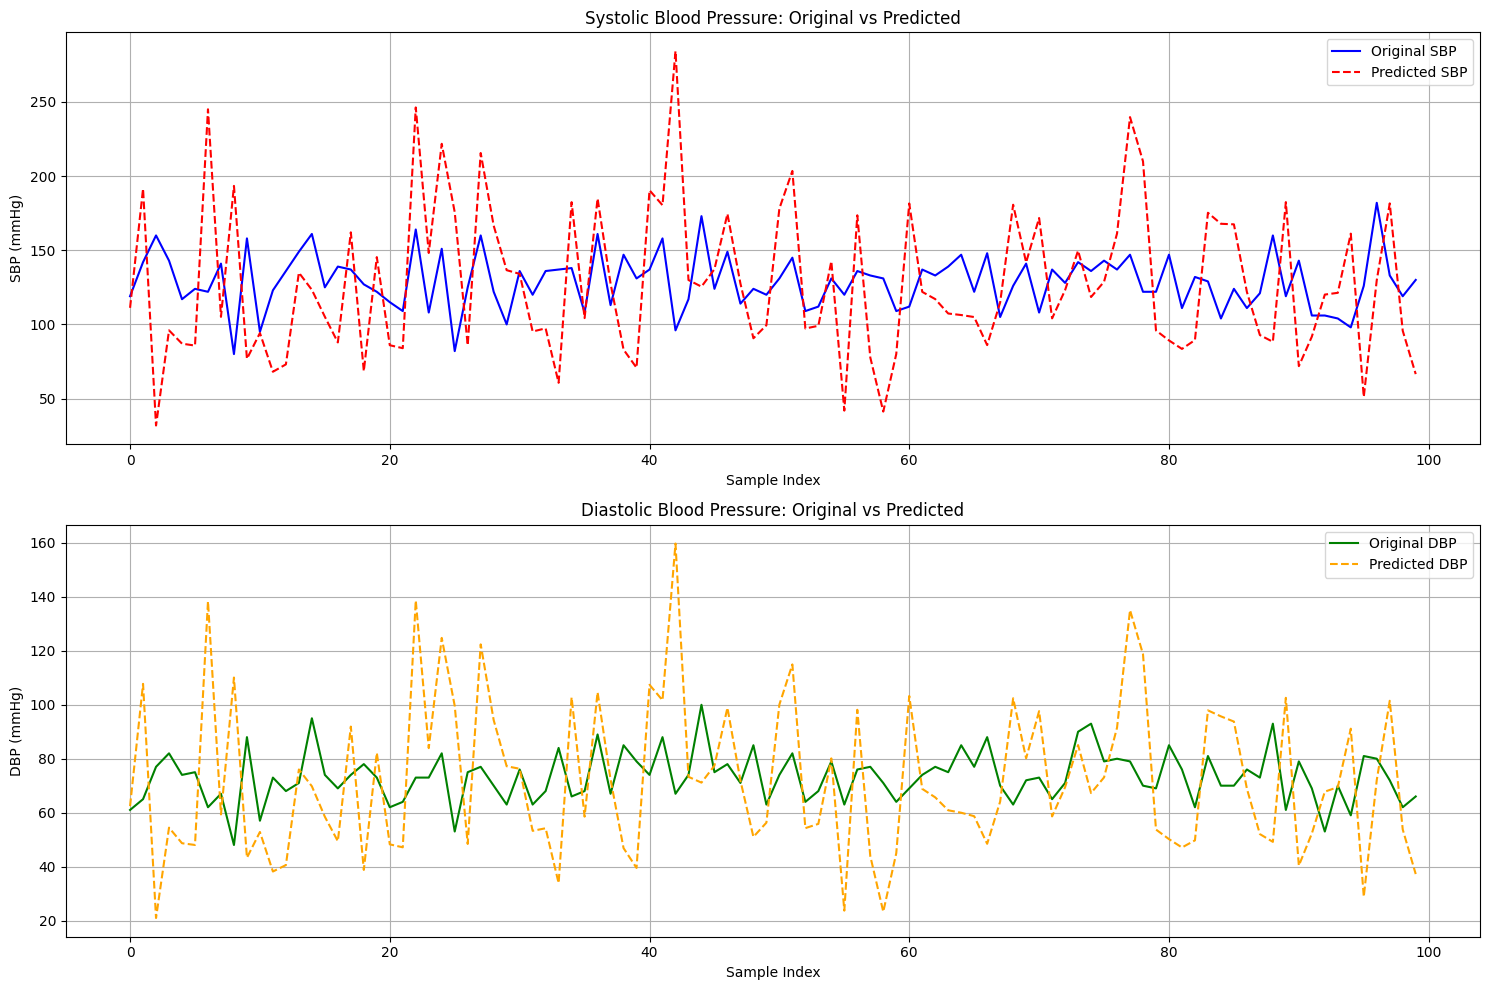

SBP Metrics:
  MAE: 43.36 mmHg
  MSE: 3086.08 mmHg²

DBP Metrics:
  MAE: 24.49 mmHg
  MSE: 980.59 mmHg²


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualization function
def visualize_predictions(y_true, y_pred, save_path='bp_predictions.png'):
    # Select first 100 samples
    y_true_subset = y_true[:100]
    y_pred_subset = y_pred[:100]

    plt.figure(figsize=(15, 10))

    # Systolic Blood Pressure
    plt.subplot(2, 1, 1)
    plt.plot(y_true_subset[:, 0], label='Original SBP', color='blue')
    plt.plot(y_pred_subset[:, 0], label='Predicted SBP', color='red', linestyle='--')
    plt.title('Systolic Blood Pressure: Original vs Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('SBP (mmHg)')
    plt.legend()
    plt.grid(True)

    # Diastolic Blood Pressure
    plt.subplot(2, 1, 2)
    plt.plot(y_true_subset[:, 1], label='Original DBP', color='green')
    plt.plot(y_pred_subset[:, 1], label='Predicted DBP', color='orange', linestyle='--')
    plt.title('Diastolic Blood Pressure: Original vs Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('DBP (mmHg)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    plt.close()

# Model evaluation
model.eval()
with torch.no_grad():
    X_test_gpu = X_test.to(device)

    # Remove the mean operation, or adjust based on your model's output
    pred_test = model(X_test_gpu, None, None, None)

    # Ensure correct dimensionality
    pred_test = pred_test.cpu().numpy()
    y_test_np = y_test.numpy()

    # Calculate MAE
    mae_sbp = mean_absolute_error(y_test_np[:, 0], pred_test[:, 0])
    mae_dbp = mean_absolute_error(y_test_np[:, 1], pred_test[:, 1])

    # Calculate MSE
    mse_sbp = mean_squared_error(y_test_np[:, 0], pred_test[:, 0])
    mse_dbp = mean_squared_error(y_test_np[:, 1], pred_test[:, 1])

    # Visualize first 100 samples
    visualize_predictions(y_test_np, pred_test)

print(f"SBP Metrics:")
print(f"  MAE: {mae_sbp:.2f} mmHg")
print(f"  MSE: {mse_sbp:.2f} mmHg²")
print(f"\nDBP Metrics:")
print(f"  MAE: {mae_dbp:.2f} mmHg")
print(f"  MSE: {mse_dbp:.2f} mmHg²")